# Mount drice

In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os
import numpy as np

In [ ]:
# Define paths
children_data_path = r"/content/drive/MyDrive/model_sim_data/child/"
adults_data_path = r"/content/drive/MyDrive/model_sim_data/adult/"
save_path = r"/content/drive/MyDrive/model_sim_data/merged-files"

In [ ]:
# Ensure the save directory exists
if not os.path.exists(save_path):
    os.makedirs(save_path)


# Function to process and aggregate individual files
def process_and_aggregate(data_path, group_label, id_label):
    all_data = []
    for file in os.listdir(data_path):
        if file.endswith(".csv"):
            file_path = os.path.join(data_path, file)
            unique_id = file.split('.')[0]  # Extract ID from filename
            data = pd.read_csv(file_path)

            # Add ID and group columns
            data[id_label] = unique_id
            data['Group'] = group_label

            # Convert 'Time' column to datetime and round to nearest hour
            data['Time'] = pd.to_datetime(data['Time'], format="%Y-%m-%d %H:%M:%S", errors='coerce')
            data['Rounded_Time'] = data['Time'].dt.round('H')

            # Drop rows with invalid time formats
            data = data.dropna(subset=['Rounded_Time'])

            # Extract temporal features
            data['Hour'] = data['Rounded_Time'].dt.hour
            data['Day_of_Week'] = data['Rounded_Time'].dt.dayofweek
            data['Is_Weekend'] = (data['Day_of_Week'] >= 5).astype(int)
            # Cyclical encoding for hour of the day
            data['Hour_Sin'] = np.sin(2 * np.pi * data['Hour'] / 24)
            data['Hour_Cos'] = np.cos(2 * np.pi * data['Hour'] / 24)

            # Aggregate data by rounded time
            aggregated_data = data.groupby(['Rounded_Time', id_label, 'Group']).agg({
                'BG': 'mean',
                'CGM': 'mean',
                'CHO': 'sum',
                'insulin': 'sum',
                'LBGI': 'mean',
                'HBGI': 'mean',
                'Risk': 'mean',
                'Hour': 'first',
                'Day_of_Week': 'first',
                'Is_Weekend': 'first',
                'Hour_Sin': 'first',
                'Hour_Cos': 'first'
            }).reset_index()

            all_data.append(aggregated_data)

    # Combine all processed files into a single DataFrame
    combined_data = pd.concat(all_data, ignore_index=True)
    return combined_data


In [ ]:
# Process children and adults datasets
children_data = process_and_aggregate(children_data_path, 'Child', 'Child_ID')
adults_data = process_and_aggregate(adults_data_path, 'Adult', 'Adult_ID')

# Combine children and adults data into a single dataset
final_combined_data = pd.concat([children_data, adults_data], ignore_index=True)

# Save final combined dataset
final_output_file = os.path.join(save_path, "final_combined_data_with_time_features.csv")
final_combined_data.to_csv(final_output_file, index=False)
print(f"Final combined data with time features saved to '{final_output_file}'.")

<ipython-input-4-aed604aba847>:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data['Rounded_Time'] = data['Time'].dt.round('H')
<ipython-input-4-aed604aba847>:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data['Rounded_Time'] = data['Time'].dt.round('H')
<ipython-input-4-aed604aba847>:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data['Rounded_Time'] = data['Time'].dt.round('H')
<ipython-input-4-aed604aba847>:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data['Rounded_Time'] = data['Time'].dt.round('H')
<ipython-input-4-aed604aba847>:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data['Rounded_Time'] = data['Time'].dt.round('H')
<ipython-input-4-aed604aba847>:21: FutureWarning: 'H' is deprecated and wil

Final combined data with time features saved to '/content/drive/MyDrive/model_sim_data/merged-files/final_combined_data_with_time_features.csv'.


In [ ]:
# Load and check the processed dataset
df = pd.read_csv(final_output_file)
print(df.head())
print(df.info())

          Rounded_Time   Child_ID  Group          BG         CGM   CHO  \
0  2025-01-06 06:00:00  child#008  Child  151.308875  155.652912   0.0   
1  2025-01-06 07:00:00  child#008  Child  151.309005  163.210155   0.0   
2  2025-01-06 08:00:00  child#008  Child  151.309921  162.659265  17.0   
3  2025-01-06 09:00:00  child#008  Child  239.228952  227.539191   6.0   
4  2025-01-06 10:00:00  child#008  Child  443.961227  427.445095   0.0   

    insulin  LBGI       HBGI       Risk  Hour  Day_of_Week  Is_Weekend  \
0  0.062333   0.0   3.063130   3.063130     6            0           0   
1  0.107667   0.0   3.063148   3.063148     7            0           0   
2  1.368800   0.0   3.063274   3.063274     8            0           0   
3  1.993192   0.0  21.154583  21.154583     9            0           0   
4  0.119000   0.0  66.811943  66.811943    10            0           0   

   Hour_Sin      Hour_Cos Adult_ID  
0  1.000000  6.123234e-17      NaN  
1  0.965926 -2.588190e-01      NaN  

#Model creation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Load the dataset
data_path = "/content/drive/MyDrive/model_sim_data/merged-files/final_combined_data_with_time_features.csv"
df = pd.read_csv(data_path)

# Select relevant features for the model
features = ['BG', 'CGM', 'CHO', 'LBGI', 'HBGI', 'Risk', 'Hour_Sin', 'Hour_Cos', 'Is_Weekend']
target = 'insulin'

# Fill missing values if any
df = df.fillna(method='ffill')

<ipython-input-6-f01dfa98840a>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


In [ ]:
# Normalize features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[features])
scaled_target = scaler.fit_transform(df[[target]])


In [ ]:
# Set time_steps to 6 (using past 6 hours of data)
time_steps = 6  # Number of previous timesteps to use (6 hours)

# Create sequences for LSTM (using 6 time steps)
def create_sequences(data, target, time_steps=6):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

# Generate sequences with 6 time steps
X, y = create_sequences(scaled_features, scaled_target, time_steps)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [ ]:
#to be deleted..
print("X_test",X_test)
print("X_train",X_train.shape)
print("X_val",X_val.shape)

X_test [[[1.37012839e-01 7.32008462e-02 0.00000000e+00 ... 3.70590477e-01
   9.82962913e-01 0.00000000e+00]
  [1.74027436e-01 1.28718642e-01 0.00000000e+00 ... 5.00000000e-01
   1.00000000e+00 0.00000000e+00]
  [2.08250736e-01 1.36981455e-01 0.00000000e+00 ... 6.29409523e-01
   9.82962913e-01 0.00000000e+00]
  ...
  [2.90973390e-01 2.07738286e-01 0.00000000e+00 ... 1.00000000e+00
   5.00000000e-01 0.00000000e+00]
  [3.18056328e-01 2.74295424e-01 0.00000000e+00 ... 1.00000000e+00
   5.00000000e-01 0.00000000e+00]
  [3.18062118e-01 2.93756506e-01 0.00000000e+00 ... 9.82962913e-01
   3.70590477e-01 0.00000000e+00]]

 [[1.51671101e-01 8.36314494e-02 0.00000000e+00 ... 6.69872981e-02
   7.50000000e-01 0.00000000e+00]
  [1.03912066e-01 2.77571260e-02 0.00000000e+00 ... 1.46446609e-01
   8.53553391e-01 0.00000000e+00]
  [6.21054155e-02 0.00000000e+00 0.00000000e+00 ... 2.50000000e-01
   9.33012702e-01 0.00000000e+00]
  ...
  [9.13696869e-02 2.80926628e-03 0.00000000e+00 ... 8.53553391e-01
   

In [ ]:
# Define the LSTM model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(time_steps, len(features)), return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False),
    Dense(16, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.0284 - mae: 0.0843 - val_loss: 0.0342 - val_mae: 0.1002
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0148 - mae: 0.0811 - val_loss: 0.0331 - val_mae: 0.0948
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0161 - mae: 0.0753 - val_loss: 0.0319 - val_mae: 0.0925
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0195 - mae: 0.0774 - val_loss: 0.0308 - val_mae: 0.0938
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0183 - mae: 0.0768 - val_loss: 0.0306 - val_mae: 0.0929
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0161 - mae: 0.0728 - val_loss: 0.0303 - val_mae: 0.0960
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0192 - mae: 0.0782 - val_loss: 0.0306 - val_mae: 0.0906
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0154 - mae: 0.0663 - val_loss: 0.0299 - val_mae: 0.0934
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.017

In [ ]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")


Test Loss: 0.0054, Test MAE: 0.0409


In [ ]:
#Make predictions
predictions = model.predict(X_test)

# Inverse transform predictions and actual values
predicted_insulin = scaler.inverse_transform(predictions)
actual_insulin = scaler.inverse_transform(y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step


In [ ]:
# Save the model
model.save("/content/drive/MyDrive/model_sim_data/lstm_insulin_model.h5")
print("LSTM model saved successfully.")


LSTM model saved successfully.


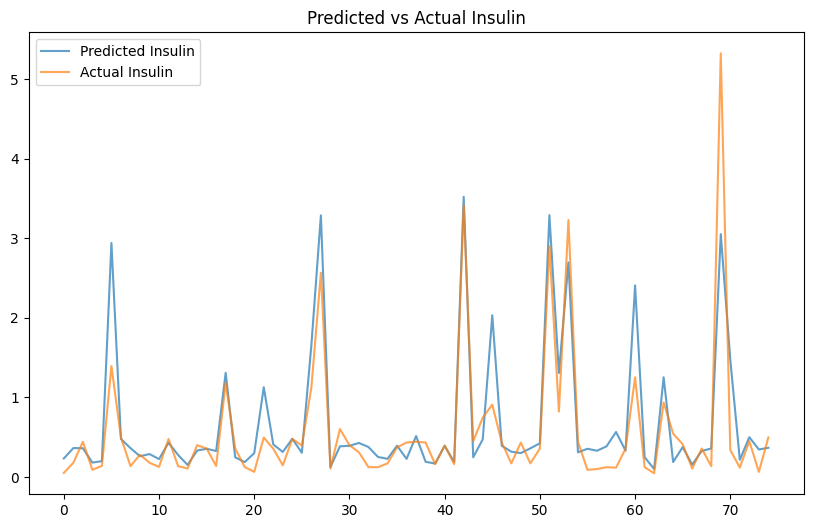

In [ ]:
# Visualize predictions vs actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(predicted_insulin, label='Predicted Insulin', alpha=0.7)
plt.plot(actual_insulin, label='Actual Insulin', alpha=0.7)
plt.legend()
plt.title("Predicted vs Actual Insulin")
plt.show()

<ipython-input-47-eca601e53aea>:29: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(timestamps[1:-1], actual_insulin[1:-1], 'o-', label='Actual Insulin', color='red', markersize=6, linestyle='-', linewidth=1)
<ipython-input-47-eca601e53aea>:30: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "x-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(timestamps[1:-1], predicted_insulin[1:-1], 'x-', label='Predicted Insulin', color='blue', markersize=6, linestyle='-', linewidth=1)


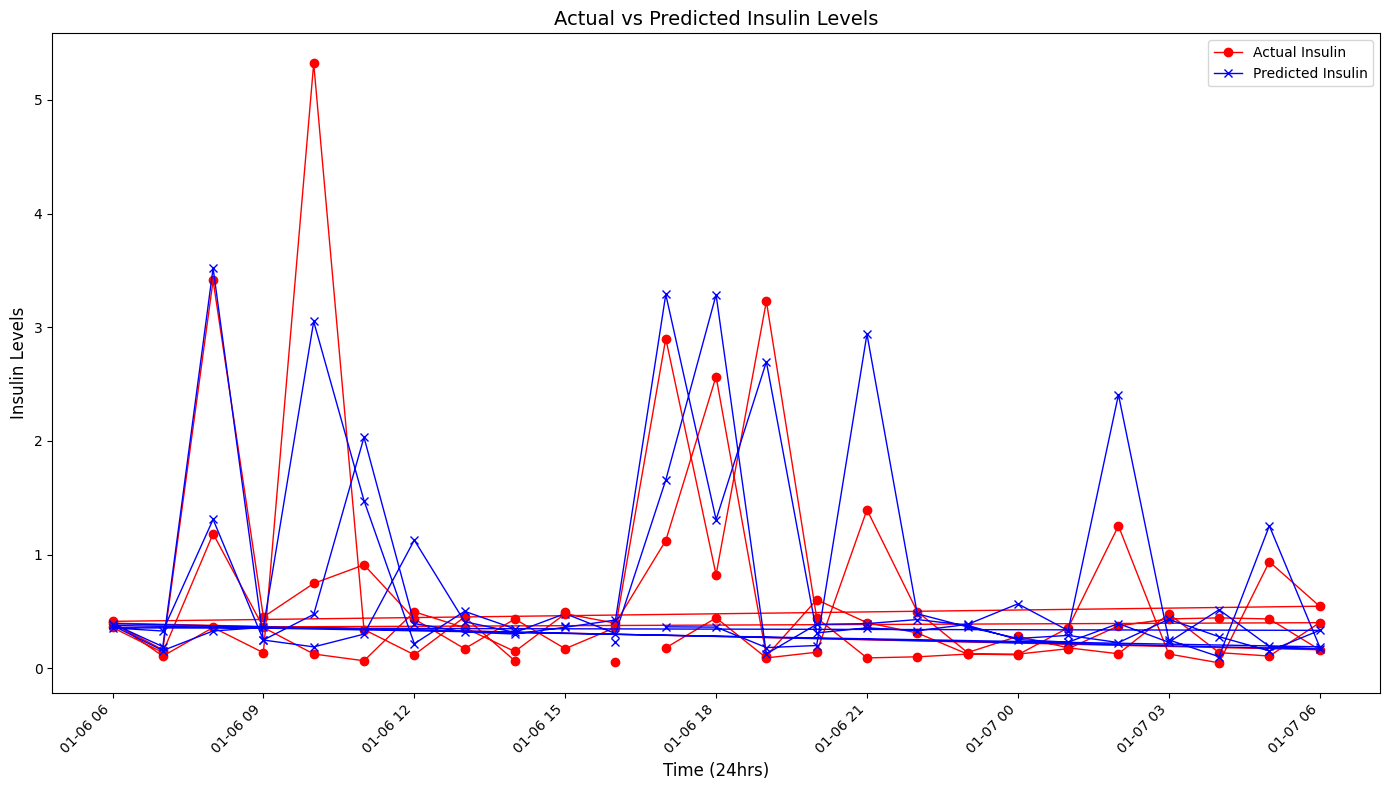

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure the 'Rounded_Time' column is in datetime format
df['Rounded_Time'] = pd.to_datetime(df['Rounded_Time'])

# Get the actual insulin values and the predicted insulin values
# We assume that y_test and predictions are already available
# Also, ensure we use the correct indices from the dataframe

# Define the time_steps (number of previous time steps used in the model input)
time_steps = 10  # Modify this as per your model

# Extract the timestamps corresponding to the test set
timestamps = df['Rounded_Time'].iloc[time_steps:len(y_test) + time_steps].reset_index(drop=True)

# Inverse transform the predictions and actual insulin values to get the original scale
predicted_insulin = scaler.inverse_transform(predictions)
actual_insulin = scaler.inverse_transform(y_test)

# Plot the graph with lines connecting the points
plt.figure(figsize=(14, 8))

# Plot the first point (no line)
plt.plot(timestamps.iloc[0], actual_insulin[0], 'o', color='red', markersize=6)
plt.plot(timestamps.iloc[0], predicted_insulin[0], 'x', color='blue', markersize=6)

# Plot the middle points (with lines connecting them)
plt.plot(timestamps[1:-1], actual_insulin[1:-1], 'o-', label='Actual Insulin', color='red', markersize=6, linestyle='-', linewidth=1)
plt.plot(timestamps[1:-1], predicted_insulin[1:-1], 'x-', label='Predicted Insulin', color='blue', markersize=6, linestyle='-', linewidth=1)

# Plot the last point (no line)
plt.plot(timestamps.iloc[-1], actual_insulin[-1], 'o', color='red', markersize=6)
plt.plot(timestamps.iloc[-1], predicted_insulin[-1], 'x', color='blue', markersize=6)

# Formatting the plot
plt.xticks(rotation=45, ha="right")
plt.xlabel("Time (24hrs)", fontsize=12)
plt.ylabel("Insulin Levels", fontsize=12)
plt.title("Actual vs Predicted Insulin Levels", fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
print("Column names:", df.columns)

Column names: Index(['Rounded_Time', 'Child_ID', 'Group', 'BG', 'CGM', 'CHO', 'insulin',
       'LBGI', 'HBGI', 'Risk', 'Hour', 'Day_of_Week', 'Is_Weekend', 'Hour_Sin',
       'Hour_Cos', 'Adult_ID'],
      dtype='object')


In [ ]:
import pandas as pd

# Ensure the 'Rounded_Time' column is in datetime format
df['Rounded_Time'] = pd.to_datetime(df['Rounded_Time'])

# Get the actual insulin values and the predicted insulin values
# We assume that y_test and predictions are already available
# Also, ensure we use the correct indices from the dataframe

# Define the time_steps (number of previous time steps used in the model input)
time_steps = 10  # Modify this as per your model

# Extract the timestamps corresponding to the test set
timestamps = df['Rounded_Time'].iloc[time_steps:len(y_test) + time_steps].reset_index(drop=True)

# Inverse transform the predictions and actual insulin values to get the original scale
predicted_insulin = scaler.inverse_transform(predictions)
actual_insulin = scaler.inverse_transform(y_test)

# Create a DataFrame to save into Excel
output_df = pd.DataFrame({
    'Rounded_Time': timestamps,
    'Actual_Insulin': actual_insulin.flatten(),
    'Predicted_Insulin': predicted_insulin.flatten()
})

# Path to save the Excel file
output_excel_path = "/content/drive/MyDrive/model_sim_data/insulin_predictions.xlsx"

# Save the DataFrame to an Excel file
output_df.to_excel(output_excel_path, index=False)

print(f"Excel file saved to: {output_excel_path}")


Excel file saved to: /content/drive/MyDrive/model_sim_data/insulin_predictions.xlsx


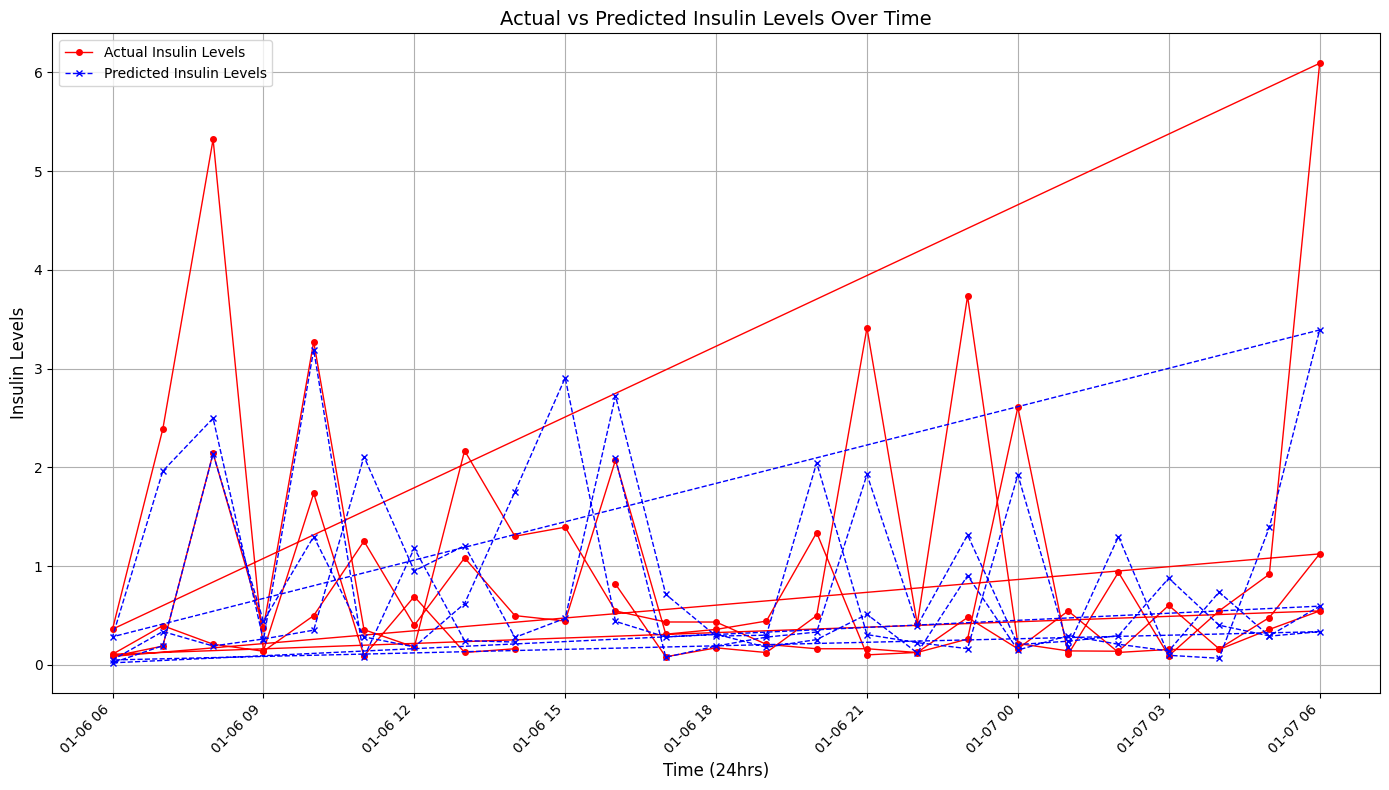

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the timestamps corresponding to the test set
# Aligning timestamps with the y_test and predictions
timestamps = df['Rounded_Time'].iloc[time_steps:time_steps + len(y_test)].reset_index(drop=True)

# Check for alignment
assert len(timestamps) == len(predictions) == len(y_test), "Mismatch in lengths of timestamps, predictions, and actual values."

# Inverse transform predictions and actual values to their original scale
actual_insulin = scaler.inverse_transform(y_test)
predicted_insulin = scaler.inverse_transform(predictions)

# Plot the actual vs predicted insulin levels over time
plt.figure(figsize=(14, 8))
plt.plot(timestamps, actual_insulin, label='Actual Insulin Levels', color='red', marker='o', linestyle='-', markersize=4, linewidth=1)
plt.plot(timestamps, predicted_insulin, label='Predicted Insulin Levels', color='blue', marker='x', linestyle='--', markersize=4, linewidth=1)

# Formatting the plot
plt.xticks(rotation=45, ha="right")
plt.xlabel("Time (24hrs)", fontsize=12)
plt.ylabel("Insulin Levels", fontsize=12)
plt.title("Actual vs Predicted Insulin Levels Over Time", fontsize=14)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Combine predicted and actual insulin levels into a DataFrame for comparison
results_df = pd.DataFrame({
    "Actual Insulin": actual_insulin.flatten(),
    "Predicted Insulin": predicted_insulin.flatten()
})

# Print the results
print("Actual vs Predicted Insulin Levels:")
print(results_df)

# Save the results to a CSV file for further analysis if needed
results_csv_path = "/content/drive/MyDrive/model_sim_data/insulin_predictions.csv"
results_df.to_csv(results_csv_path, index=False)
print(f"Results saved to {results_csv_path}")


Actual vs Predicted Insulin Levels:
    Actual Insulin  Predicted Insulin
0         0.818075           2.090794
1         0.082083           0.077311
2         0.172375           0.190330
3         0.124925           0.281056
4         0.498925           0.332379
..             ...                ...
69        1.737342           3.192402
70        0.091517           0.077108
71        0.692150           1.181070
72        0.125875           0.245290
73        0.163083           0.231203

[74 rows x 2 columns]
Results saved to /content/drive/MyDrive/model_sim_data/insulin_predictions.csv


In [ ]:
import matplotlib.pyplot as plt

# Select a specific child ID (e.g., 'child#008')
child_id = 'child#008'

# Filter the dataset for the selected Child_ID
df_child = df[df['Child_ID'] == child_id]

# Get the actual insulin levels for this child (this will match the original insulin values)
actual_insulin = df_child['insulin'].values

# Get the corresponding features for the selected child (scaled)
features_child = df_child[features].values
scaled_features_child = scaler.transform(features_child)

# Create sequences for this child's data
X_child, y_child = create_sequences(scaled_features_child, scaled_target, time_steps=6)

# Predict insulin using the trained model
predictions_child = model.predict(X_child)

# Inverse transform predictions to get actual insulin units
predicted_insulin_child = scaler.inverse_transform(predictions_child)

# Plot the actual vs predicted insulin levels
plt.figure(figsize=(10, 6))

# Plot the actual insulin levels
plt.plot(df_child['Rounded_Time'][time_steps:], actual_insulin[time_steps:], label='Actual Insulin', color='blue')

# Plot the predicted insulin levels
plt.plot(df_child['Rounded_Time'][time_steps:], predicted_insulin_child, label='Predicted Insulin', color='red', linestyle='--')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Insulin Levels')
plt.title(f'Actual vs Predicted Insulin Levels for {child_id}')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


ValueError: X has 9 features, but MinMaxScaler is expecting 1 features as input.

##Correct Model (code)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Load the dataset
data_path = "/content/drive/MyDrive/model_sim_data/merged-files/final_combined_data_with_time_features.csv"
df = pd.read_csv(data_path)

# Select relevant features for the model
features = ['BG', 'CGM', 'CHO', 'LBGI', 'HBGI', 'Risk', 'Hour_Sin', 'Hour_Cos', 'Is_Weekend']
target = 'insulin'

# Fill missing values if any
df = df.fillna(method='ffill')

<ipython-input-22-f01dfa98840a>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


In [ ]:
df.head()

,Rounded_Time,Child_ID,Group,BG,CGM,CHO,insulin,LBGI,HBGI,Risk,Hour,Day_of_Week,Is_Weekend,Hour_Sin,Hour_Cos,Adult_ID
0,2025-01-06 06:00:00,child#008,Child,151.308875,155.652912,0.0,0.062333,0.0,3.063130,3.063130,6,0,0,1.000000,6.123234e-17,NaN
1,2025-01-06 07:00:00,child#008,Child,151.309005,163.210155,0.0,0.107667,0.0,3.063148,3.063148,7,0,0,0.965926,-2.588190e-01,NaN
2,2025-01-06 08:00:00,child#008,Child,151.309921,162.659265,17.0,1.368800,0.0,3.063274,3.063274,8,0,0,0.866025,-5.000000e-01,NaN
3,2025-01-06 09:00:00,child#008,Child,239.228952,227.539191,6.0,1.993192,0.0,21.154583,21.154583,9,0,0,0.707107,-7.071068e-01,NaN
4,2025-01-06 10:00:00,child#008,Child,443.961227,427.445095,0.0,0.119000,0.0,66.811943,66.811943,10,0,0,0.500000,-8.660254e-01,NaN


In [ ]:
# Separate the features and target from the dataset
X = df[features].values  # Features
y = df['insulin'].values  # Target

# Initialize the MinMaxScaler
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# Scale the features and target independently
scaled_features = scaler_features.fit_transform(X)
scaled_target = scaler_target.fit_transform(y.reshape(-1, 1))


In [ ]:
# Create sequences for LSTM (assuming time steps of 6 hours)
def create_sequences(data, target, time_steps=6):
    X_seq, y_seq = [], []
    for i in range(len(data) - time_steps):
        X_seq.append(data[i:i + time_steps])
        y_seq.append(target[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

# Set the time steps as 6 hours
time_steps = 6
X_seq, y_seq = create_sequences(scaled_features, scaled_target, time_steps)

# Split the data into training, validation, and test sets
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [ ]:
# Define the LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    LSTM(128, activation='relu', input_shape=(time_steps, len(features)), return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(16, activation='relu'),
    Dense(1)  # Output layer for regression
])

In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.0226 - mae: 0.0768 - val_loss: 0.0325 - val_mae: 0.0882
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0140 - mae: 0.0638 - val_loss: 0.0307 - val_mae: 0.1027
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0133 - mae: 0.0707 - val_loss: 0.0310 - val_mae: 0.1061
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0188 - mae: 0.0824 - val_loss: 0.0312 - val_mae: 0.0861
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0197 - mae: 0.0771 - val_loss: 0.0297 - val_mae: 0.0881
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0145 - mae: 0.0647 - val_loss: 0.0289 - val_mae: 0.0954
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0154 - mae: 0.0687 - val_loss: 0.0289 - val_mae: 0.0913
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0153 - mae: 0.0704 - val_loss: 0.0293 - val_mae: 0.0887
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


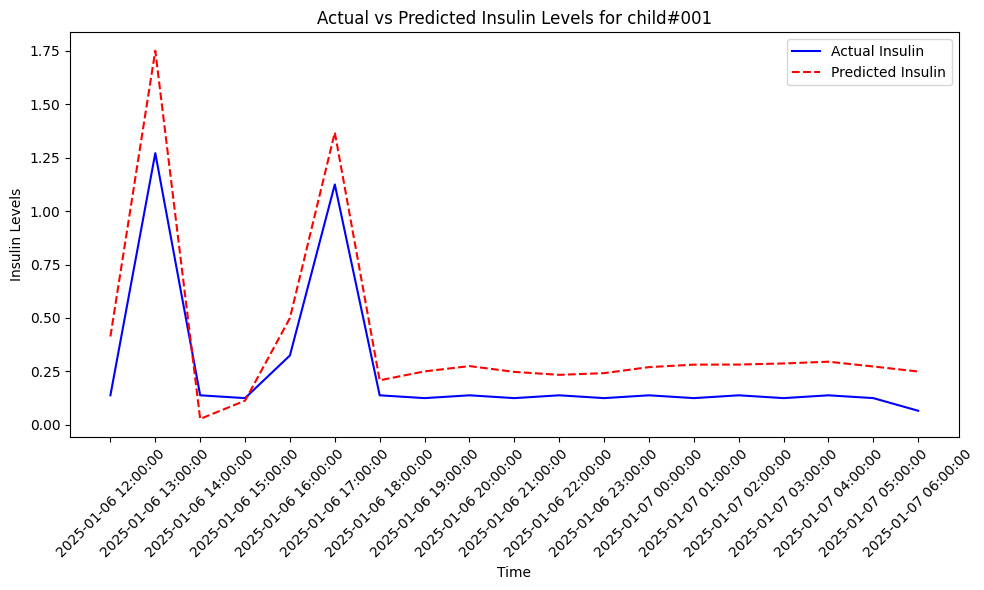

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


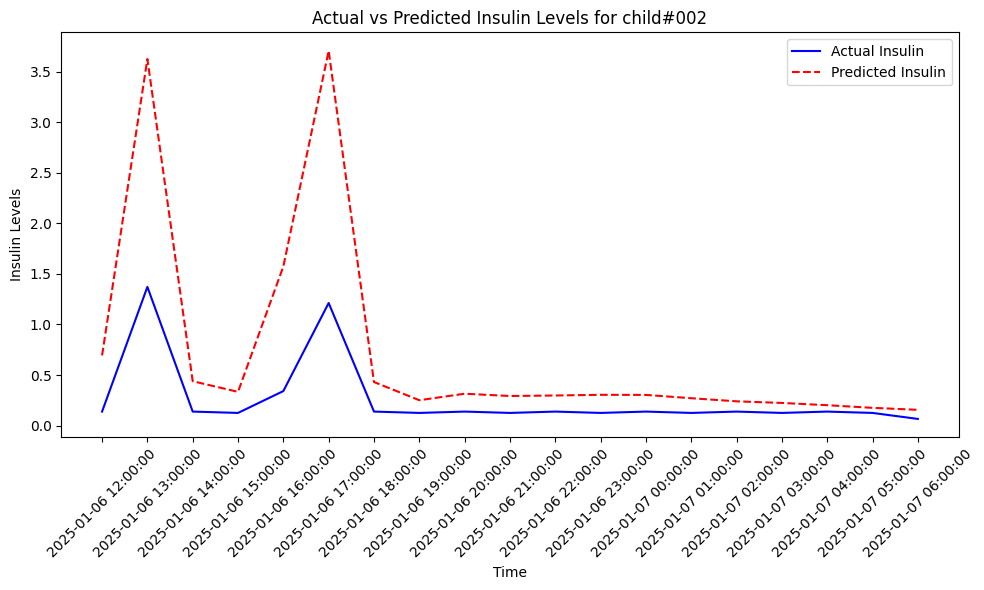

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


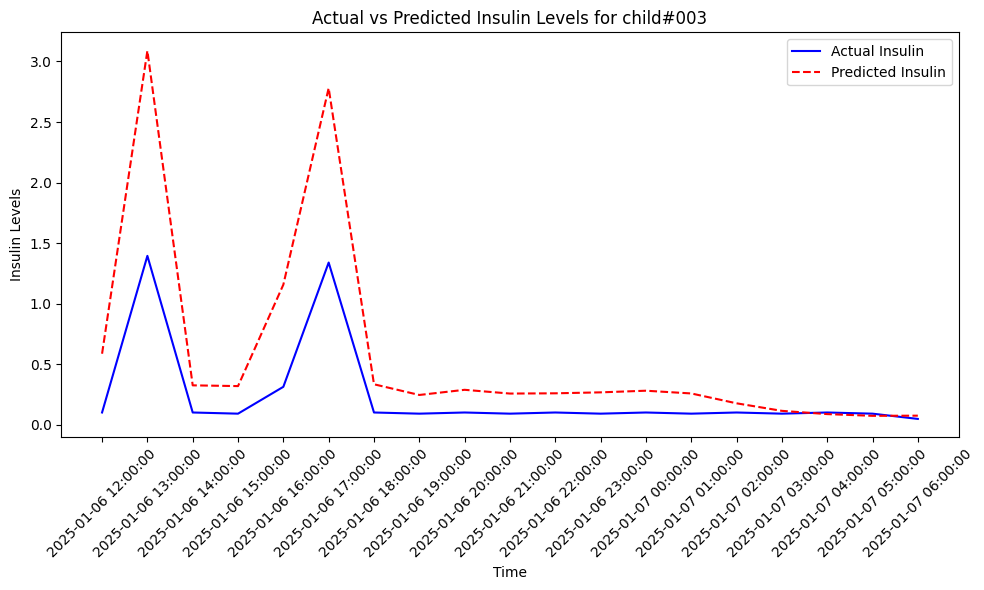

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


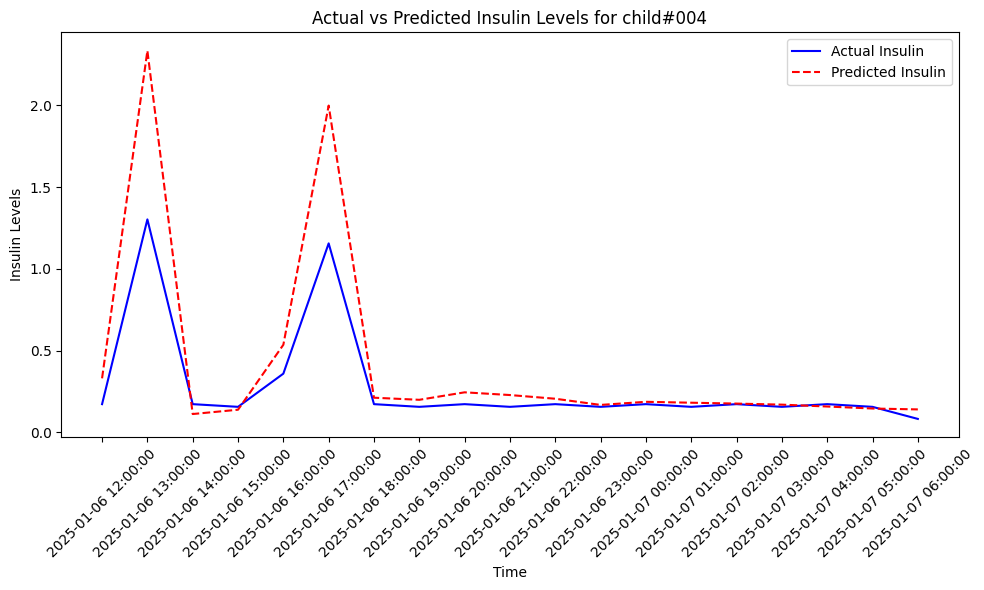

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


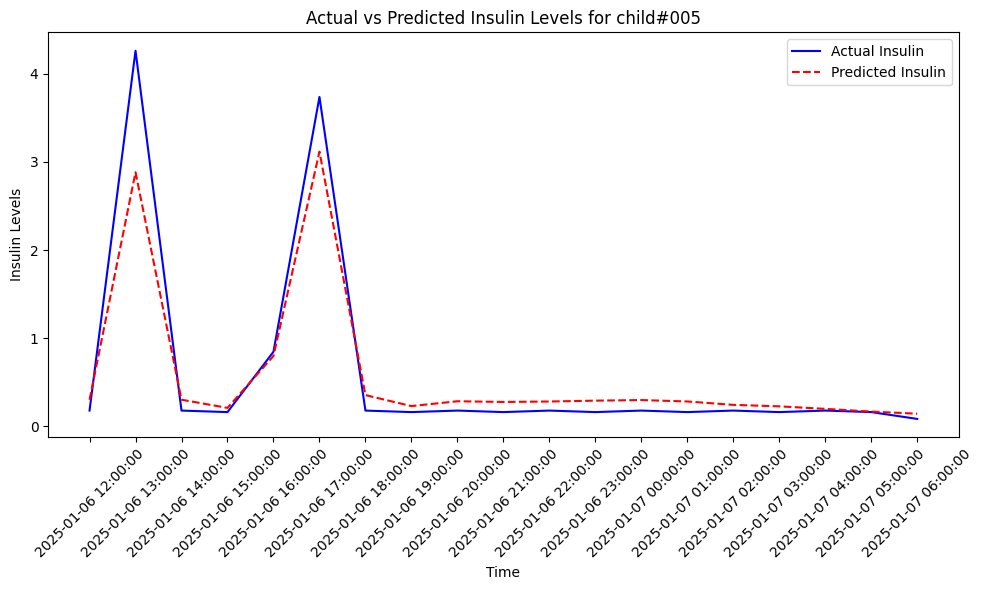

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


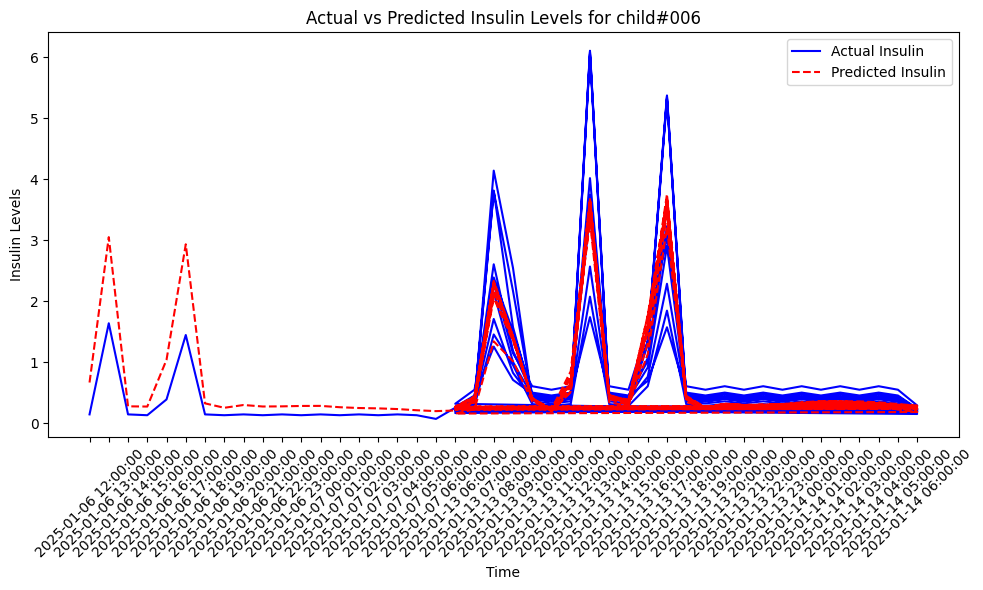

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


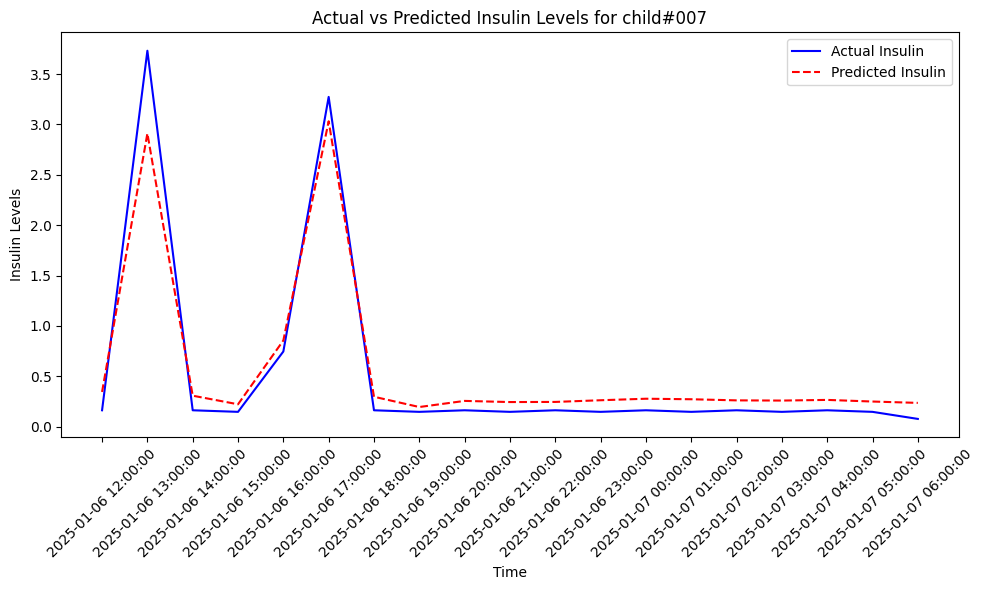

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


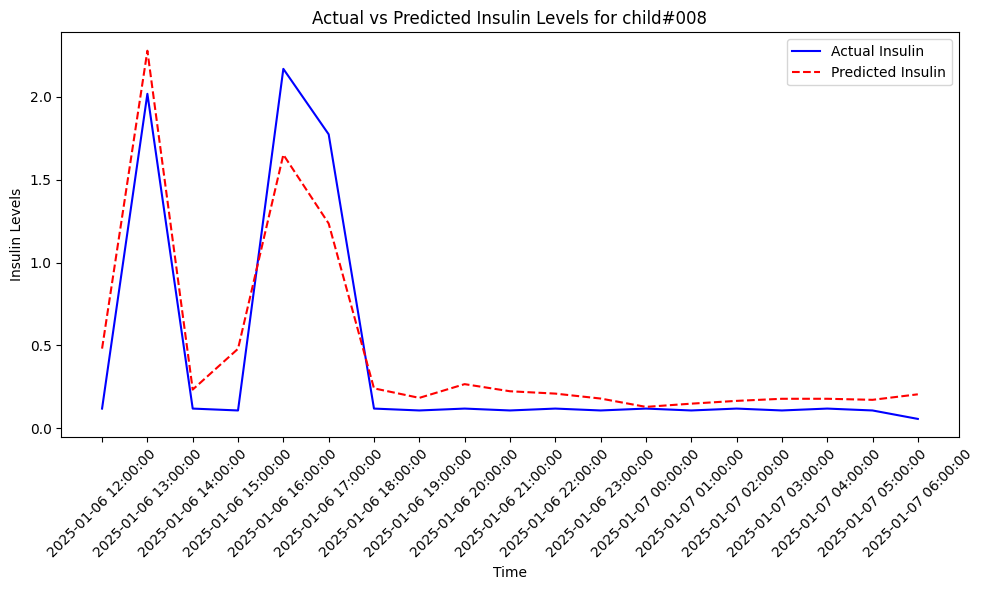

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


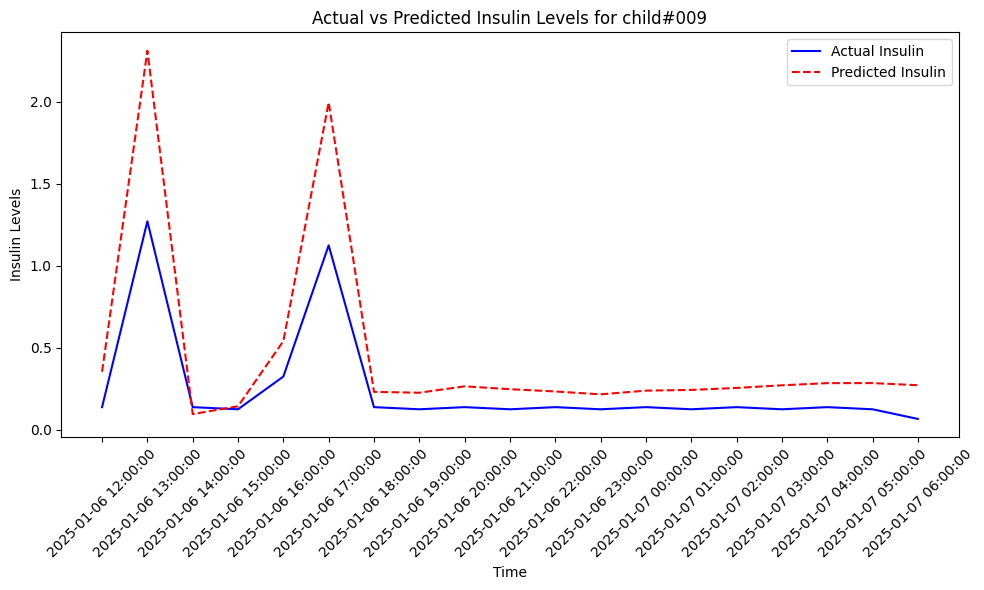

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


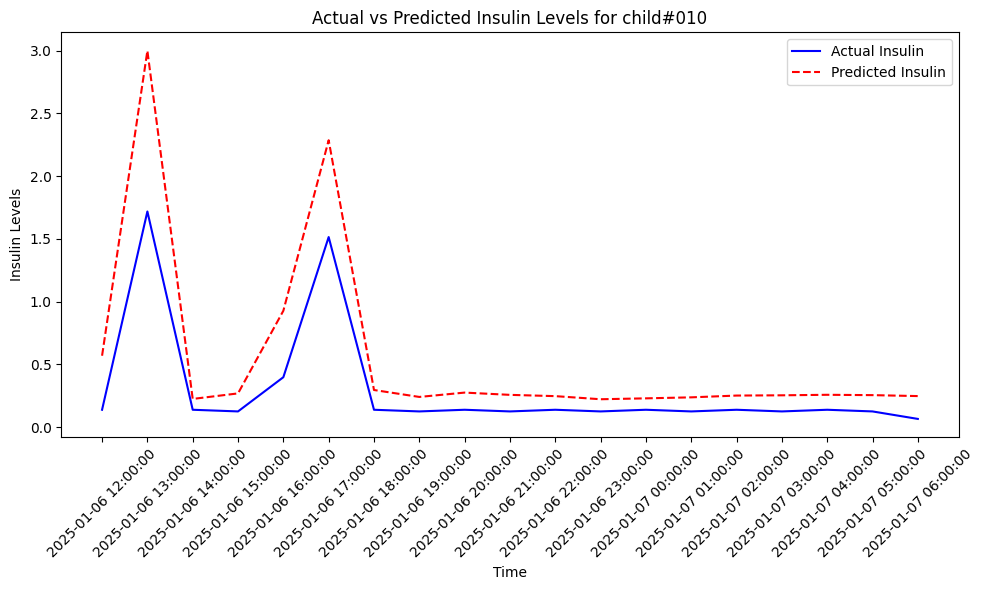

In [ ]:
import matplotlib.pyplot as plt

# Function to plot actual vs predicted insulin levels for a specific child
def plot_actual_vs_predicted_for_child(child_id):
    # Filter the data for the selected child
    df_child = df[df['Child_ID'] == child_id]

    # Get the actual insulin levels for this child
    actual_insulin = df_child['insulin'].values

    # Get the corresponding features for the selected child
    features_child = df_child[features].values
    scaled_features_child = scaler_features.transform(features_child)

    # Create sequences for this child's data
    X_child, y_child = create_sequences(scaled_features_child, scaled_target, time_steps)

    # Predict insulin using the trained model
    predictions_child = model.predict(X_child)

    # Inverse transform predictions to get actual insulin values
    predicted_insulin_child = scaler_target.inverse_transform(predictions_child)

    # Plot the actual vs predicted insulin levels
    plt.figure(figsize=(10, 6))

    # Plot the actual insulin levels
    plt.plot(df_child['Rounded_Time'][time_steps:], actual_insulin[time_steps:], label='Actual Insulin', color='blue')

    # Plot the predicted insulin levels
    plt.plot(df_child['Rounded_Time'][time_steps:], predicted_insulin_child, label='Predicted Insulin', color='red', linestyle='--')

    # Add labels and title
    plt.xlabel('Time')
    plt.ylabel('Insulin Levels')
    plt.title(f'Actual vs Predicted Insulin Levels for {child_id}')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Add legend
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

# Generate plots for all 10 children
for i in range(1, 11):
    child_id = f'child#{i:03d}'  # child#001, child#002, ..., child#010
    plot_actual_vs_predicted_for_child(child_id)

In [ ]:

# Function to collect actual vs predicted insulin values for each child/adult
def collect_actual_vs_predicted(child_id):
    # Filter the data for the selected child or adult
    df_person = df[df['Child_ID'] == child_id]

    # Check if the dataframe is empty
    if df_person.empty:
        print(f"No data found for {child_id}")
        return pd.DataFrame()  # Return an empty DataFrame if no data found

    # Get the actual insulin levels for this person
    actual_insulin = df_person['insulin'].values

    # Get the corresponding features for the selected person
    features_person = df_person[features].values
    scaled_features_person = scaler_features.transform(features_person)

    # Create sequences for this person's data
    X_person, y_person = create_sequences(scaled_features_person, scaled_target, time_steps)

    # Predict insulin using the trained model
    predictions_person = model.predict(X_person)

    # Inverse transform predictions to get actual insulin values
    predicted_insulin_person = scaler_target.inverse_transform(predictions_person)

    # Create a DataFrame to hold the actual and predicted insulin values
    result_df = pd.DataFrame({
        'Rounded_Time': df_person['Rounded_Time'][time_steps:],  # Skipping the first `time_steps` rows
        'Child_ID': [child_id] * len(actual_insulin[time_steps:]),  # Repeat the child_id for the same number of rows
        'Actual_Insulin': actual_insulin[time_steps:],  # Skipping the first `time_steps` rows
        'Predicted_Insulin': predicted_insulin_person.flatten()  # Flatten to match shape
    })

    return result_df

# Collect actual vs predicted insulin values for all children and adults
all_results = pd.DataFrame()

# Loop through all child IDs and collect results
for i in range(1, 11):  # child#001 to child#010
    child_id = f'child#{i:03d}'
    child_results = collect_actual_vs_predicted(child_id)
    if not child_results.empty:  # Only append if data exists
        all_results = pd.concat([all_results, child_results], ignore_index=True)

# Loop through all adult IDs and collect results
for i in range(1, 11):  # adult#001 to adult#010
    adult_id = f'adult#{i:03d}'
    adult_results = collect_actual_vs_predicted(adult_id)
    if not adult_results.empty:  # Only append if data exists
        all_results = pd.concat([all_results, adult_results], ignore_index=True)

# Save the results to a CSV file
all_results.to_csv('actual_vs_predicted_insulin.csv', index=False)

print("Results saved to 'actual_vs_predicted_insulin.csv'")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
No data found for adult#001
No data found for adult#002
No data found for adult#003
No data found for adult#004
No data found for adult#005
No data found for adult#006
No data found for adult#007
No data found for adult#008
No data found for adult#009
No data found for adult#010
Results saved to 'actual_vs_predicted_insulin.csv'


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # Import necessary metrics
# Evaluate the model on the test set
y_pred_test = model.predict(X_test)
y_pred_test_inv = scaler_target.inverse_transform(y_pred_test)
y_test_inv = scaler_target.inverse_transform(y_test)

# Calculate evaluation metrics for the test set
r2_test = r2_score(y_test_inv, y_pred_test_inv)
mae_test = mean_absolute_error(y_test_inv, y_pred_test_inv)
mse_test = mean_squared_error(y_test_inv, y_pred_test_inv)
rmse_test = np.sqrt(mse_test)

# Print test set evaluation metrics
print("\nTest Set Evaluation Metrics:")
print(f"R² Score: {r2_test:.4f}")
print(f"Mean Absolute Error (MAE): {mae_test:.4f}")
print(f"Mean Squared Error (MSE): {mse_test:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_test:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Test Set Evaluation Metrics:
R² Score: 0.7547
Mean Absolute Error (MAE): 0.2576
Mean Squared Error (MSE): 0.1843
Root Mean Squared Error (RMSE): 0.4293


In [ ]:
# Define the save path
save_path = r"/content/drive/MyDrive/model_sim_data/merged-files"

# Define the output file name
output_file = os.path.join(save_path, 'actual_vs_predicted_insulin.csv')

# Save the DataFrame to the specified file
all_results.to_csv(output_file, index=False)

print(f"Results saved to '{output_file}'")


Results saved to '/content/drive/MyDrive/model_sim_data/merged-files/actual_vs_predicted_insulin.csv'


# 1 month testing

In [ ]:
import os
import pandas as pd
import numpy as np

# Define paths for the new 1-month simulation data
base_data_path = r"/content/drive/MyDrive/model_sim_data/1_month_simulation/"
children_data_path = os.path.join(base_data_path, "child/")
adults_data_path = os.path.join(base_data_path, "adult/")
adolescents_data_path = os.path.join(base_data_path, "adolescent/")
save_path = r"/content/drive/MyDrive/model_sim_data/merged-files"

In [ ]:
# Ensure the save directory exists
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Function to process and aggregate individual files
def process_and_aggregate(data_path, group_label, id_label):
    all_data = []
    for file in os.listdir(data_path):
        if file.endswith(".csv"):
            file_path = os.path.join(data_path, file)
            unique_id = file.split('.')[0]  # Extract ID from filename
            data = pd.read_csv(file_path)

            # Add ID and group columns
            data[id_label] = unique_id
            data['Group'] = group_label

            # Convert 'Time' column to datetime and round to nearest hour
            data['Time'] = pd.to_datetime(data['Time'], format="%Y-%m-%d %H:%M:%S", errors='coerce')
            data['Rounded_Time'] = data['Time'].dt.round('H')

            # Drop rows with invalid time formats
            data = data.dropna(subset=['Rounded_Time'])

            # Extract temporal features
            data['Hour'] = data['Rounded_Time'].dt.hour
            data['Day_of_Week'] = data['Rounded_Time'].dt.dayofweek
            data['Is_Weekend'] = (data['Day_of_Week'] >= 5).astype(int)
            # Cyclical encoding for hour of the day
            data['Hour_Sin'] = np.sin(2 * np.pi * data['Hour'] / 24)
            data['Hour_Cos'] = np.cos(2 * np.pi * data['Hour'] / 24)

            # Aggregate data by rounded time
            aggregated_data = data.groupby(['Rounded_Time', id_label, 'Group']).agg({
                'BG': 'mean',
                'CGM': 'mean',
                'CHO': 'sum',
                'insulin': 'sum',
                'LBGI': 'mean',
                'HBGI': 'mean',
                'Risk': 'mean',
                'Hour': 'first',
                'Day_of_Week': 'first',
                'Is_Weekend': 'first',
                'Hour_Sin': 'first',
                'Hour_Cos': 'first'
            }).reset_index()

            all_data.append(aggregated_data)

    # Combine all processed files into a single DataFrame
    combined_data = pd.concat(all_data, ignore_index=True)
    return combined_data

In [ ]:
# Process children, adults, and adolescents datasets
children_data = process_and_aggregate(children_data_path, 'Child', 'Child_ID')
adults_data = process_and_aggregate(adults_data_path, 'Adult', 'Adult_ID')
adolescents_data = process_and_aggregate(adolescents_data_path, 'Adolescent', 'Adolescent_ID')

# Combine all three groups into a single dataset
final_combined_data = pd.concat([children_data, adults_data, adolescents_data], ignore_index=True)

<ipython-input-28-5972f6d3eb81>:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data['Rounded_Time'] = data['Time'].dt.round('H')
<ipython-input-28-5972f6d3eb81>:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data['Rounded_Time'] = data['Time'].dt.round('H')
<ipython-input-28-5972f6d3eb81>:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data['Rounded_Time'] = data['Time'].dt.round('H')
<ipython-input-28-5972f6d3eb81>:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data['Rounded_Time'] = data['Time'].dt.round('H')
<ipython-input-28-5972f6d3eb81>:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data['Rounded_Time'] = data['Time'].dt.round('H')
<ipython-input-28-5972f6d3eb81>:20: FutureWarning: 'H' is deprecated a

In [ ]:
# Save final combined dataset
final_output_file = os.path.join(save_path, "final_combined_1month_data_with_time_features.csv")
final_combined_data.to_csv(final_output_file, index=False)
print(f"Final combined 1-month data with time features saved to '{final_output_file}'.")

Final combined 1-month data with time features saved to '/content/drive/MyDrive/model_sim_data/merged-files/final_combined_1month_data_with_time_features.csv'.


In [ ]:
final_combined_data.head()

,Rounded_Time,Child_ID,Group,BG,CGM,CHO,insulin,LBGI,HBGI,Risk,Hour,Day_of_Week,Is_Weekend,Hour_Sin,Hour_Cos,Adult_ID,Adolescent_ID
0,2025-01-01 00:00:00,child#003,Child,133.831059,138.175099,0.0,0.052983,0.0,1.048293,1.048293,0,2,0,0.000000,1.000000,NaN,NaN
1,2025-01-01 01:00:00,child#003,Child,133.829354,145.730592,0.0,0.091517,0.0,1.048139,1.048139,1,2,0,0.258819,0.965926,NaN,NaN
2,2025-01-01 02:00:00,child#003,Child,133.819308,145.168908,0.0,0.101150,0.0,1.047231,1.047231,2,2,0,0.500000,0.866025,NaN,NaN
3,2025-01-01 03:00:00,child#003,Child,133.803595,126.382902,0.0,0.091517,0.0,1.045810,1.045810,3,2,0,0.707107,0.707107,NaN,NaN
4,2025-01-01 04:00:00,child#003,Child,133.787970,116.589962,0.0,0.101150,0.0,1.044399,1.044399,4,2,0,0.866025,0.500000,NaN,NaN


In [ ]:
# Load and check the processed dataset
df = pd.read_csv(final_output_file)
print(df.head())
print(df.info())

          Rounded_Time   Child_ID  Group          BG         CGM  CHO  \
0  2025-01-01 00:00:00  child#003  Child  133.831059  138.175099  0.0   
1  2025-01-01 01:00:00  child#003  Child  133.829354  145.730592  0.0   
2  2025-01-01 02:00:00  child#003  Child  133.819308  145.168908  0.0   
3  2025-01-01 03:00:00  child#003  Child  133.803595  126.382902  0.0   
4  2025-01-01 04:00:00  child#003  Child  133.787970  116.589962  0.0   

    insulin  LBGI      HBGI      Risk  Hour  Day_of_Week  Is_Weekend  \
0  0.052983   0.0  1.048293  1.048293     0            2           0   
1  0.091517   0.0  1.048139  1.048139     1            2           0   
2  0.101150   0.0  1.047231  1.047231     2            2           0   
3  0.091517   0.0  1.045810  1.045810     3            2           0   
4  0.101150   0.0  1.044399  1.044399     4            2           0   

   Hour_Sin  Hour_Cos Adult_ID Adolescent_ID  
0  0.000000  1.000000      NaN           NaN  
1  0.258819  0.965926      NaN    

#model building on 1 month data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [ ]:
# Load the new 1-month dataset
data_path = r"/content/drive/MyDrive/model_sim_data/merged-files/final_combined_1month_data_with_time_features.csv"
df = pd.read_csv(data_path)

# Select relevant features for the model
features = ['BG', 'CGM', 'CHO', 'LBGI', 'HBGI', 'Risk', 'Hour_Sin', 'Hour_Cos', 'Is_Weekend']
target = 'insulin'

# Fill missing values
df = df.fillna(method='ffill')

# Display first few rows
print(df.head())

          Rounded_Time   Child_ID  Group          BG         CGM  CHO  \
0  2025-01-01 00:00:00  child#003  Child  133.831059  138.175099  0.0   
1  2025-01-01 01:00:00  child#003  Child  133.829354  145.730592  0.0   
2  2025-01-01 02:00:00  child#003  Child  133.819308  145.168908  0.0   
3  2025-01-01 03:00:00  child#003  Child  133.803595  126.382902  0.0   
4  2025-01-01 04:00:00  child#003  Child  133.787970  116.589962  0.0   

    insulin  LBGI      HBGI      Risk  Hour  Day_of_Week  Is_Weekend  \
0  0.052983   0.0  1.048293  1.048293     0            2           0   
1  0.091517   0.0  1.048139  1.048139     1            2           0   
2  0.101150   0.0  1.047231  1.047231     2            2           0   
3  0.091517   0.0  1.045810  1.045810     3            2           0   
4  0.101150   0.0  1.044399  1.044399     4            2           0   

   Hour_Sin  Hour_Cos Adult_ID Adolescent_ID  
0  0.000000  1.000000      NaN           NaN  
1  0.258819  0.965926      NaN    

<ipython-input-42-913711466647>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


In [ ]:
# Scale features and target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

X = scaler_features.fit_transform(df[features].values)
y = scaler_target.fit_transform(df[target].values.reshape(-1, 1))

# Create sequences
def create_sequences(data, target, time_steps=6):
    X_seq, y_seq = [], []
    for i in range(len(data) - time_steps):
        X_seq.append(data[i:i + time_steps])
        y_seq.append(target[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

In [ ]:
time_steps = 6
X_seq, y_seq = create_sequences(X, y, time_steps)

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
# Define and compile LSTM model
model = Sequential([
    LSTM(128, activation='relu', input_shape=(time_steps, len(features)), return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(16, activation='relu'),
    Dense(1)  # Output layer for insulin prediction
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


946/946 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 0.0098 - mae: 0.0532 - val_loss: 0.0091 - val_mae: 0.0583
Epoch 2/100
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 0.0081 - mae: 0.0468 - val_loss: 0.0078 - val_mae: 0.0468
Epoch 3/100
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0083 - mae: 0.0464 - val_loss: 0.0079 - val_mae: 0.0398
Epoch 4/100
946/946 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.0082 - mae: 0.0453 - val_loss: 0.0076 - val_mae: 0.0486
Epoch 5/100
946/946 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 0.0075 - mae: 0.0432 - val_loss: 0.0073 - val_mae: 0.0442
Epoch 6/100
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 0.0075 - mae: 0.0435 - val_loss: 0.0072 - val_mae: 0.0429
Epoch 7/100
946/946 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 0.0074 - mae: 0.0428 - val_loss: 0.0069 - val_mae: 0.0391
Epoch 8/100
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0071 - mae: 0.0416 - val_loss: 0.0070 - val_mae: 0.0416
Epoch 9/100
946/946 ━━━━━━━━━━━━━━━━━━━━ 20s

In [ ]:
# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest MAE: {test_mae:.4f}")
print(f"Test Loss (MSE): {test_loss:.4f}")


Test MAE: 0.0352
Test Loss (MSE): 0.0057


In [ ]:
# Function to plot actual vs predicted insulin levels for a specific individual
def plot_actual_vs_predicted(individual_id, group):
    # Determine the correct ID column based on group
    id_column = f"{group}_ID"

    # Filter data for the selected individual
    df_individual = df[(df['Group'] == group) & (df[id_column] == individual_id)]

    if len(df_individual) <= time_steps:
        print(f"Not enough data for {individual_id} in {group} group")
        return

    # Get actual insulin and features
    actual_insulin = df_individual[target].values
    features_individual = df_individual[features].values

    # Scale features
    scaled_features_individual = scaler_features.transform(features_individual)

    # Create sequences
    X_individual, y_individual = create_sequences(scaled_features_individual,
                                                 scaler_target.transform(actual_insulin.reshape(-1, 1)),
                                                 time_steps)

    # Predict insulin
    predictions = model.predict(X_individual, verbose=0)
    predicted_insulin = scaler_target.inverse_transform(predictions)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(df_individual['Rounded_Time'].iloc[time_steps:],
             actual_insulin[time_steps:],
             label='Actual Insulin',
             color='blue')
    plt.plot(df_individual['Rounded_Time'].iloc[time_steps:],
             predicted_insulin,
             label='Predicted Insulin',
             color='red',
             linestyle='--')

    plt.xlabel('Time')
    plt.ylabel('Insulin Levels')
    plt.title(f'Actual vs Predicted Insulin Levels for {individual_id} ({group})')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# Generate plots for sample individuals from each group
groups = ['Child', 'Adult', 'Adolescent']
for group in groups:
    # Get unique IDs for this group
    id_column = f"{group}_ID"
    unique_ids = df[df['Group'] == group][id_column].unique()

    # Plot for up to 3 individuals per group (if available)
    for i, individual_id in enumerate(unique_ids[:3]):
        if pd.notna(individual_id):  # Check for valid ID
            print(f"Generating plot for {individual_id} in {group} group")
            plot_actual_vs_predicted(individual_id, group)

Output hidden; open in https://colab.research.google.com to view.

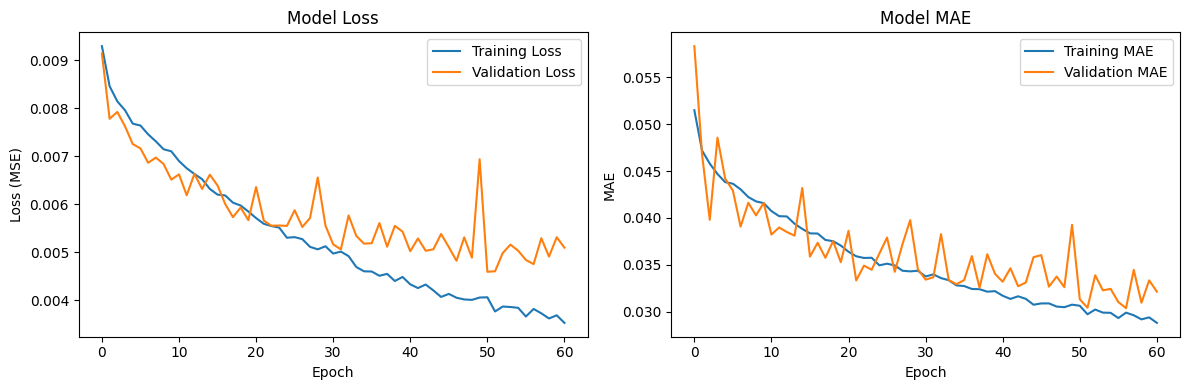

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Block for Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt  # Import the sqrt function


In [ ]:
# Block for Evaluation Metrics
def print_evaluation_metrics(y_true, y_pred, dataset_name=""):
    """
    Calculate and print various evaluation metrics

    Parameters:
    y_true: Actual values
    y_pred: Predicted values
    dataset_name: Name of the dataset (e.g., 'Validation', 'Test')
    """
    # Ensure inputs are numpy arrays and flattened
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Print metrics
    print(f"\nEvaluation Metrics for {dataset_name} Set:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

# After training, get predictions
val_predictions = model.predict(X_val, verbose=0)
test_predictions = model.predict(X_test, verbose=0)

# Inverse transform predictions and actual values to original scale
val_predictions_original = scaler_target.inverse_transform(val_predictions)
y_val_original = scaler_target.inverse_transform(y_val)
test_predictions_original = scaler_target.inverse_transform(test_predictions)
y_test_original = scaler_target.inverse_transform(y_test)

# Print evaluation metrics for validation set
print_evaluation_metrics(y_val_original, val_predictions_original, "Validation")

# Print evaluation metrics for test set
print_evaluation_metrics(y_test_original, test_predictions_original, "Test")


Evaluation Metrics for Validation Set:
Mean Squared Error (MSE): 0.3434
Mean Absolute Error (MAE): 0.2709
Root Mean Squared Error (RMSE): 0.5860
R² Score: 0.5478

Evaluation Metrics for Test Set:
Mean Squared Error (MSE): 0.4278
Mean Absolute Error (MAE): 0.3042
Root Mean Squared Error (RMSE): 0.6541
R² Score: 0.5413


# above code updated versiobn

In [ ]:
#mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from datetime import timedelta

In [ ]:
# Load the new 1-month dataset
data_path = r"/content/drive/MyDrive/model_sim_data/merged-files/final_combined_1month_data_with_time_features.csv"
df = pd.read_csv(data_path)

# Select relevant features for the model
features = ['BG', 'CGM', 'CHO', 'LBGI', 'HBGI', 'Risk', 'Hour_Sin', 'Hour_Cos', 'Is_Weekend']
target = 'insulin'

In [ ]:
# Fill missing values
df = df.fillna(method='ffill')

# Ensure 'Rounded_Time' is in datetime format
df['Rounded_Time'] = pd.to_datetime(df['Rounded_Time'])

# Scale features and target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

X = scaler_features.fit_transform(df[features].values)
y = scaler_target.fit_transform(df[target].values.reshape(-1, 1))

<ipython-input-7-001c9075682a>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


In [ ]:
# Create sequences
def create_sequences(data, target, time_steps=12):  # Increased to 12 for more context
    X_seq, y_seq = [], []
    for i in range(len(data) - time_steps):
        X_seq.append(data[i:i + time_steps])
        y_seq.append(target[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

time_steps = 12
X_seq, y_seq = create_sequences(X, y, time_steps)

In [ ]:
# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
# Define and compile updated LSTM model
model = Sequential([
    LSTM(256, activation='relu', input_shape=(time_steps, len(features)), return_sequences=True),
    Dropout(0.2),
    LSTM(128, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(1)  # Output layer for insulin prediction
])

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/150
473/473 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - loss: 0.0107 - mae: 0.0545 - val_loss: 0.0101 - val_mae: 0.0690
Epoch 2/150
473/473 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0104 - mae: 0.0546 - val_loss: 0.0087 - val_mae: 0.0524
Epoch 3/150
473/473 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0093 - mae: 0.0509 - val_loss: 0.0086 - val_mae: 0.0447
Epoch 4/150
473/473 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0088 - mae: 0.0479 - val_loss: 0.0080 - val_mae: 0.0497
Epoch 5/150
473/473 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0087 - mae: 0.0478 - val_loss: 0.0078 - val_mae: 0.0450
Epoch 6/150
473/473 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0080 - mae: 0.0453 - val_loss: 0.0077 - val_mae: 0.0475
Epoch 7/150
473/473 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0080 - mae: 0.0454 - val_loss: 0.0077 - val_mae: 0.0469
Epoch 8/150
473/473 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0082 - mae: 0.0454 - val_loss: 0.0073 - val_mae: 0.0442
Epoch 9/150
473/473 ━━━━━━━━━━━━━━━━━━━━ 5s 7m

In [ ]:
# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest MAE: {test_mae:.4f}")
print(f"Test Loss (MSE): {test_loss:.4f}")


Test MAE: 0.0265
Test Loss (MSE): 0.0033


In [ ]:
# Function to plot actual vs predicted insulin levels for a specific individual over 1 week
def plot_actual_vs_predicted_week(individual_id, group, start_date=None):
    id_column = f"{group}_ID"
    df_individual = df[(df['Group'] == group) & (df[id_column] == individual_id)].copy()  # Fixed typo here

    if len(df_individual) <= time_steps:
        print(f"Not enough data for {individual_id} in {group} group")
        return

    # If no start_date provided, use the earliest date in the data
    if start_date is None:
        start_date = df_individual['Rounded_Time'].min()

    # Define 1-week period
    end_date = start_date + timedelta(days=7)

    # Filter for 1-week span
    df_week = df_individual[
        (df_individual['Rounded_Time'] >= start_date) &
        (df_individual['Rounded_Time'] < end_date)
    ]

    if len(df_week) <= time_steps:
        print(f"Not enough data for {individual_id} in {group} group for the selected week")
        return

    # Get actual insulin and features
    actual_insulin = df_week[target].values
    features_week = df_week[features].values

    # Scale features
    scaled_features_week = scaler_features.transform(features_week)

    # Create sequences
    X_week, y_week = create_sequences(scaled_features_week,
                                     scaler_target.transform(actual_insulin.reshape(-1, 1)),
                                     time_steps)

    # Predict insulin
    predictions = model.predict(X_week, verbose=0)
    predicted_insulin = scaler_target.inverse_transform(predictions)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df_week['Rounded_Time'].iloc[time_steps:],
             actual_insulin[time_steps:],
             label='Actual Insulin',
             color='blue')
    plt.plot(df_week['Rounded_Time'].iloc[time_steps:],
             predicted_insulin,
             label='Predicted Insulin',
             color='red',
             linestyle='--')

    plt.xlabel('Time')
    plt.ylabel('Insulin Dosage')
    plt.title(f'Actual vs Predicted Insulin Dosage for {individual_id} ({group}) - 1 Week')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

Generating plot for child#003 in Child group


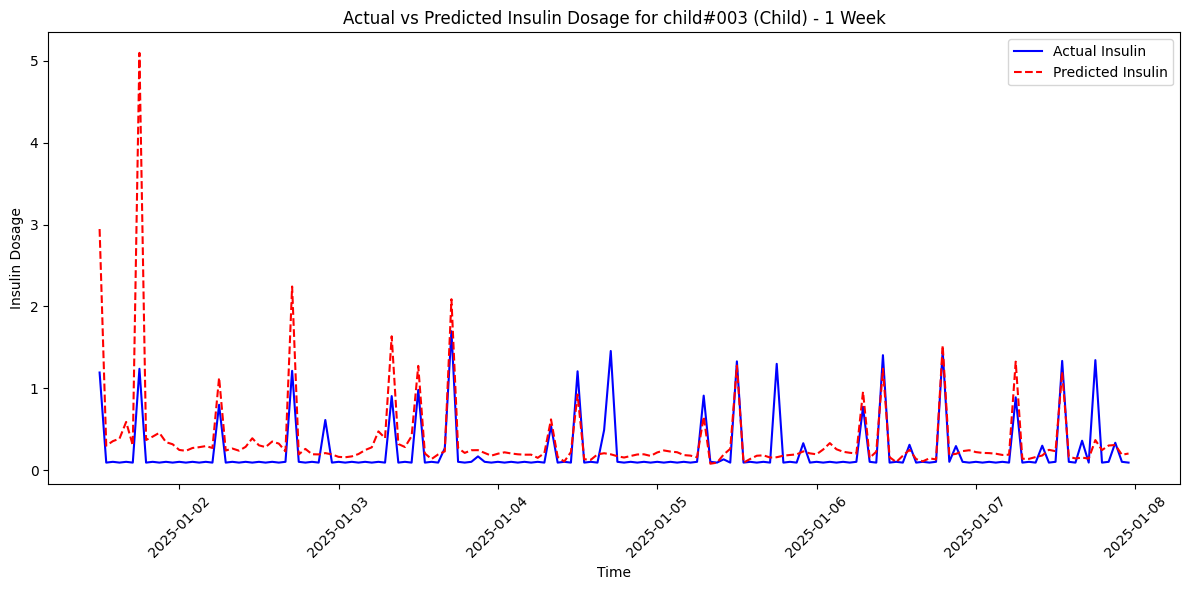

Generating plot for adult#002 in Adult group


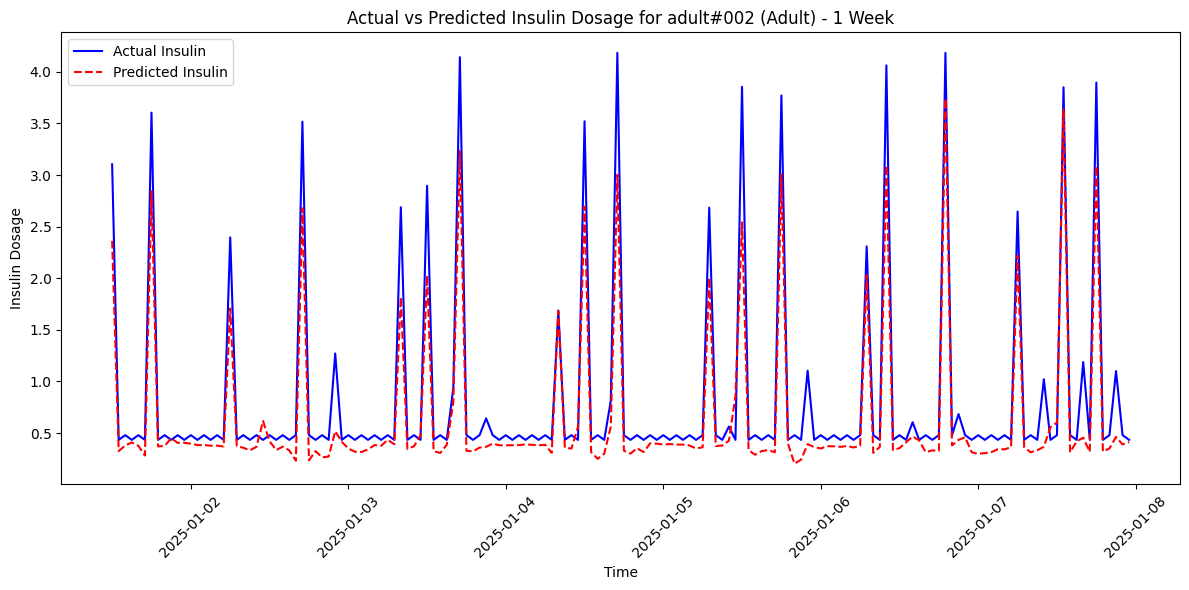

Generating plot for adolescent#010 in Adolescent group


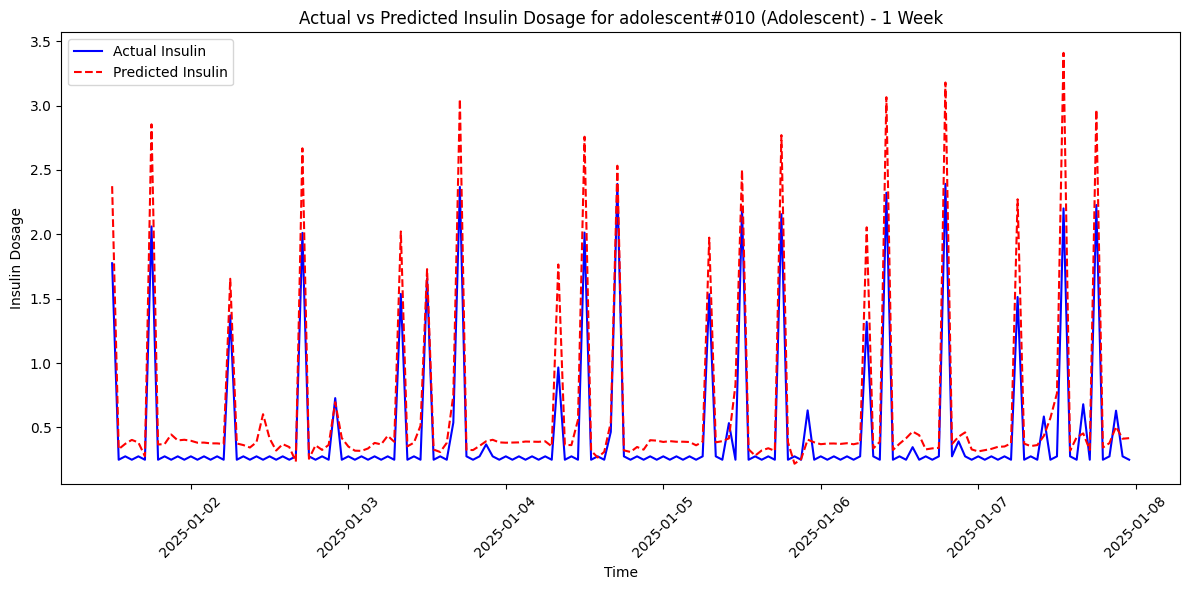

In [ ]:
# Generate plots for sample individuals from each group
groups = ['Child', 'Adult', 'Adolescent']
for group in groups:
    id_column = f"{group}_ID"
    unique_ids = df[df['Group'] == group][id_column].unique()
    for i, individual_id in enumerate(unique_ids[:1]):  # Limit to 1 individual per group for brevity
        if pd.notna(individual_id):
            print(f"Generating plot for {individual_id} in {group} group")
            plot_actual_vs_predicted_week(individual_id, group)  # Default to first week

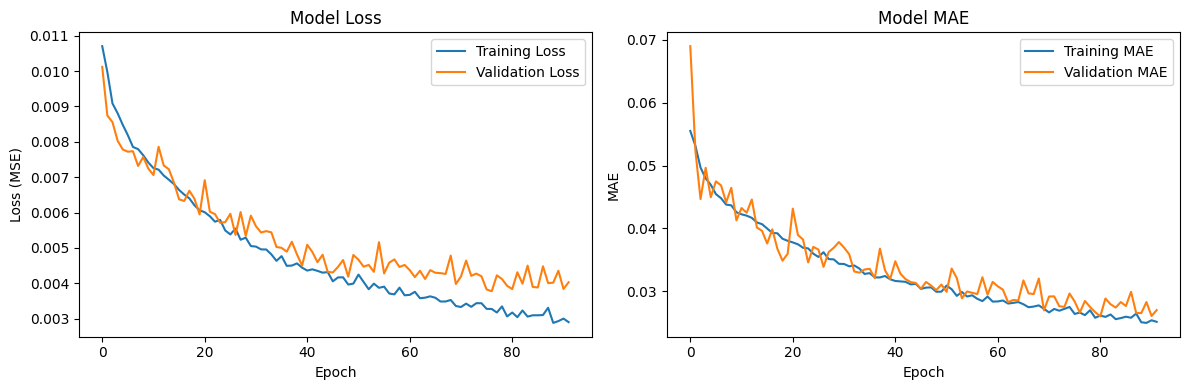

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluation Metrics
def print_evaluation_metrics(y_true, y_pred, dataset_name=""):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\nEvaluation Metrics for {dataset_name} Set:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

# Get predictions and inverse transform
val_predictions = model.predict(X_val, verbose=0)
test_predictions = model.predict(X_test, verbose=0)

val_predictions_original = scaler_target.inverse_transform(val_predictions)
y_val_original = scaler_target.inverse_transform(y_val)
test_predictions_original = scaler_target.inverse_transform(test_predictions)
y_test_original = scaler_target.inverse_transform(y_test)

# Print evaluation metrics
print_evaluation_metrics(y_val_original, val_predictions_original, "Validation")
print_evaluation_metrics(y_test_original, test_predictions_original, "Test")


Evaluation Metrics for Validation Set:
Mean Squared Error (MSE): 0.2822
Mean Absolute Error (MAE): 0.2301
Root Mean Squared Error (RMSE): 0.5312
R² Score: 0.6297

Evaluation Metrics for Test Set:
Mean Squared Error (MSE): 0.2480
Mean Absolute Error (MAE): 0.2294
Root Mean Squared Error (RMSE): 0.4980
R² Score: 0.6659


In [ ]:
# Block to calculate percentage of predictions within ±1 unit of actual values
def calculate_percentage_within_tolerance(y_true, y_pred, tolerance=1.0, dataset_name=""):
    """
    Calculate the percentage of predictions within a specified tolerance of actual values.

    Parameters:
    y_true: Actual values (in original scale)
    y_pred: Predicted values (in original scale)
    tolerance: The acceptable difference (default ±1 unit)
    dataset_name: Name of the dataset (e.g., 'Validation', 'Test')
    """
    # Ensure inputs are flattened numpy arrays
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    # Calculate absolute differences
    differences = np.abs(y_true - y_pred)

    # Count how many predictions are within tolerance
    within_tolerance = np.sum(differences <= tolerance)

    # Calculate percentage
    total_instances = len(y_true)
    percentage = (within_tolerance / total_instances) * 100

    print(f"\nPercentage of predictions within ±{tolerance} unit for {dataset_name} Set: {percentage:.2f}%")
    return percentage

# Calculate for validation set
calculate_percentage_within_tolerance(y_val_original, val_predictions_original, tolerance=1.0, dataset_name="Validation")

# Calculate for test set
calculate_percentage_within_tolerance(y_test_original, test_predictions_original, tolerance=1.0, dataset_name="Test")


Percentage of predictions within ±1.0 unit for Validation Set: 94.70%

Percentage of predictions within ±1.0 unit for Test Set: 94.76%


np.float64(94.75794017884674)

# (Final)Simple Averaging Ensemble of LSTM and GRU Models R2 : 0.77 Accuracy of 95%

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from datetime import timedelta

In [ ]:
# Load the dataset
data_path = r"/content/drive/MyDrive/model_sim_data/merged-files/final_combined_1month_data_with_time_features.csv"
df = pd.read_csv(data_path)

# Select relevant features for the model
features = ['BG', 'CGM', 'CHO', 'LBGI', 'HBGI', 'Risk', 'Hour_Sin', 'Hour_Cos', 'Is_Weekend']
target = 'insulin'

# Fill missing values
df = df.fillna(method='ffill')

# Ensure 'Rounded_Time' is in datetime format
df['Rounded_Time'] = pd.to_datetime(df['Rounded_Time'])

<ipython-input-33-51b5dbb1cb39>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


In [ ]:
# Scale features and target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

X = scaler_features.fit_transform(df[features].values)
y = scaler_target.fit_transform(df[target].values.reshape(-1, 1))

In [ ]:
# Create sequences
def create_sequences(data, target, time_steps=24):
    X_seq, y_seq = [], []
    for i in range(len(data) - time_steps):
        X_seq.append(data[i:i + time_steps])
        y_seq.append(target[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

time_steps = 24
X_seq, y_seq = create_sequences(X, y, time_steps)

In [ ]:
# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
# Define LSTM model (your current base model)
lstm_model = Sequential([
    Bidirectional(LSTM(256, activation='relu', return_sequences=True),
                  input_shape=(time_steps, len(features))),
    Dropout(0.3),
    Bidirectional(LSTM(128, activation='relu', return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64, activation='relu', return_sequences=False)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

lstm_optimizer = Adam(learning_rate=0.0003)
lstm_model.compile(optimizer=lstm_optimizer, loss='mse', metrics=['mae'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Define GRU model
gru_model = Sequential([
    GRU(256, activation='relu', return_sequences=True, input_shape=(time_steps, len(features))),
    Dropout(0.3),
    GRU(128, activation='relu', return_sequences=True),
    Dropout(0.3),
    GRU(64, activation='relu', return_sequences=False),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

gru_optimizer = Adam(learning_rate=0.0003)
gru_model.compile(optimizer=gru_optimizer, loss='mse', metrics=['mae'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train both models
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train LSTM model
lstm_history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 29s 62ms/step - loss: 0.0104 - mae: 0.0544 - val_loss: 0.0118 - val_mae: 0.0502
Epoch 2/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.0097 - mae: 0.0508 - val_loss: 0.0104 - val_mae: 0.0503
Epoch 3/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0089 - mae: 0.0491 - val_loss: 0.0101 - val_mae: 0.0497
Epoch 4/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0086 - mae: 0.0479 - val_loss: 0.0099 - val_mae: 0.0482
Epoch 5/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0078 - mae: 0.0453 - val_loss: 0.0095 - val_mae: 0.0521
Epoch 6/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0080 - mae: 0.0456 - val_loss: 0.0095 - val_mae: 0.0463
Epoch 7/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0070 - mae: 0.0417 - val_loss: 0.0093 - val_mae: 0.0465
Epoch 8/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0073 - mae: 0.0436 - val_loss: 0.0092 - val_mae: 0.0441
Epoch 9/100
237/237 ━━━━━━━━━━━━━━━━━

In [ ]:
# Train GRU model
gru_history = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200
237/237 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - loss: 0.0108 - mae: 0.0543 - val_loss: 0.0111 - val_mae: 0.0528
Epoch 2/200
237/237 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0088 - mae: 0.0496 - val_loss: 0.0108 - val_mae: 0.0485
Epoch 3/200
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0083 - mae: 0.0469 - val_loss: 0.0104 - val_mae: 0.0487
Epoch 4/200
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0081 - mae: 0.0463 - val_loss: 0.0103 - val_mae: 0.0531
Epoch 5/200
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0088 - mae: 0.0477 - val_loss: 0.0101 - val_mae: 0.0505
Epoch 6/200
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0085 - mae: 0.0464 - val_loss: 0.0099 - val_mae: 0.0486
Epoch 7/200
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0083 - mae: 0.0465 - val_loss: 0.0104 - val_mae: 0.0461
Epoch 8/200
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0077 - mae: 0.0446 - val_loss: 0.0100 - val_mae: 0.0485
Epoch 9/200
237/237 ━━━━━━━━━━━━━━━━━━━

In [ ]:
# Get predictions from both models
lstm_val_preds = lstm_model.predict(X_val, verbose=0)
lstm_test_preds = lstm_model.predict(X_test, verbose=0)
gru_val_preds = gru_model.predict(X_val, verbose=0)
gru_test_preds = gru_model.predict(X_test, verbose=0)

# Ensemble: Average the predictions
ensemble_val_preds = (lstm_val_preds + gru_val_preds) / 2
ensemble_test_preds = (lstm_test_preds + gru_test_preds) / 2

In [ ]:
# Inverse transform predictions and actual values
lstm_val_preds_original = scaler_target.inverse_transform(lstm_val_preds)
lstm_test_preds_original = scaler_target.inverse_transform(lstm_test_preds)
gru_val_preds_original = scaler_target.inverse_transform(gru_val_preds)
gru_test_preds_original = scaler_target.inverse_transform(gru_test_preds)
ensemble_val_preds_original = scaler_target.inverse_transform(ensemble_val_preds)
ensemble_test_preds_original = scaler_target.inverse_transform(ensemble_test_preds)
y_val_original = scaler_target.inverse_transform(y_val)
y_test_original = scaler_target.inverse_transform(y_test)

In [ ]:
# Evaluation Metrics
def print_evaluation_metrics(y_true, y_pred, dataset_name="", model_name=""):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\nEvaluation Metrics for {dataset_name} Set ({model_name}):")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

# Print metrics for individual models and ensemble
print_evaluation_metrics(y_val_original, lstm_val_preds_original, "Validation", "LSTM")
print_evaluation_metrics(y_test_original, lstm_test_preds_original, "Test", "LSTM")
print_evaluation_metrics(y_val_original, gru_val_preds_original, "Validation", "GRU")
print_evaluation_metrics(y_test_original, gru_test_preds_original, "Test", "GRU")
print_evaluation_metrics(y_val_original, ensemble_val_preds_original, "Validation", "Ensemble")
print_evaluation_metrics(y_test_original, ensemble_test_preds_original, "Test", "Ensemble")


Evaluation Metrics for Validation Set (LSTM):
Mean Squared Error (MSE): 0.2593
Mean Absolute Error (MAE): 0.2196
Root Mean Squared Error (RMSE): 0.5092
R² Score: 0.7315

Evaluation Metrics for Test Set (LSTM):
Mean Squared Error (MSE): 0.1877
Mean Absolute Error (MAE): 0.1964
Root Mean Squared Error (RMSE): 0.4332
R² Score: 0.7581

Evaluation Metrics for Validation Set (GRU):
Mean Squared Error (MSE): 0.2434
Mean Absolute Error (MAE): 0.2251
Root Mean Squared Error (RMSE): 0.4934
R² Score: 0.7479

Evaluation Metrics for Test Set (GRU):
Mean Squared Error (MSE): 0.2047
Mean Absolute Error (MAE): 0.2186
Root Mean Squared Error (RMSE): 0.4524
R² Score: 0.7362

Evaluation Metrics for Validation Set (Ensemble):
Mean Squared Error (MSE): 0.2337
Mean Absolute Error (MAE): 0.2119
Root Mean Squared Error (RMSE): 0.4835
R² Score: 0.7580

Evaluation Metrics for Test Set (Ensemble):
Mean Squared Error (MSE): 0.1789
Mean Absolute Error (MAE): 0.1967
Root Mean Squared Error (RMSE): 0.4229
R² Score:

In [ ]:
# Percentage within ±1 unit
def calculate_percentage_within_tolerance(y_true, y_pred, tolerance=1.0, dataset_name="", model_name=""):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    differences = np.abs(y_true - y_pred)
    within_tolerance = np.sum(differences <= tolerance)
    total_instances = len(y_true)
    percentage = (within_tolerance / total_instances) * 100
    print(f"\nPercentage of predictions within ±{tolerance} unit for {dataset_name} Set ({model_name}): {percentage:.2f}%")
    return percentage

# Calculate percentage for ensemble
calculate_percentage_within_tolerance(y_val_original, ensemble_val_preds_original, tolerance=1.0, dataset_name="Validation", model_name="Ensemble")
calculate_percentage_within_tolerance(y_test_original, ensemble_test_preds_original, tolerance=1.0, dataset_name="Test", model_name="Ensemble")


Percentage of predictions within ±1.0 unit for Validation Set (Ensemble): 94.94%

Percentage of predictions within ±1.0 unit for Test Set (Ensemble): 95.46%


np.float64(95.46436285097192)

In [ ]:
def plot_actual_vs_predicted_week(individual_id, group, start_date=None):
    id_column = f"{group}_ID"
    df_individual = df[(df['Group'] == group) & (df[id_column] == individual_id)].copy()
    if len(df_individual) <= time_steps:
        print(f"Not enough data for {individual_id} in {group} group")
        return
    if start_date is None:
        start_date = df_individual['Rounded_Time'].min()
    end_date = start_date + timedelta(days=7)
    df_week = df_individual[(df_individual['Rounded_Time'] >= start_date) & (df_individual['Rounded_Time'] < end_date)]
    if len(df_week) <= time_steps:
        print(f"Not enough data for {individual_id} in {group} group for the selected week")
        return
    actual_insulin = df_week[target].values
    features_week = df_week[features].values
    scaled_features_week = scaler_features.transform(features_week)
    X_week, _ = create_sequences(scaled_features_week, scaler_target.transform(actual_insulin.reshape(-1, 1)), time_steps)
    lstm_preds = lstm_model.predict(X_week, verbose=0)
    gru_preds = gru_model.predict(X_week, verbose=0)
    ensemble_preds = (lstm_preds + gru_preds) / 2
    predicted_insulin = scaler_target.inverse_transform(ensemble_preds)
    plt.figure(figsize=(12, 6))
    plt.plot(df_week['Rounded_Time'].iloc[time_steps:], actual_insulin[time_steps:], label='Actual Insulin', color='blue')
    plt.plot(df_week['Rounded_Time'].iloc[time_steps:], predicted_insulin, label='Predicted Insulin (Ensemble)', color='red', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Insulin Dosage')
    plt.title(f'Actual vs Predicted Insulin Dosage for {individual_id} ({group}) - 1 Week')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

Generating plot for child#003 in Child group


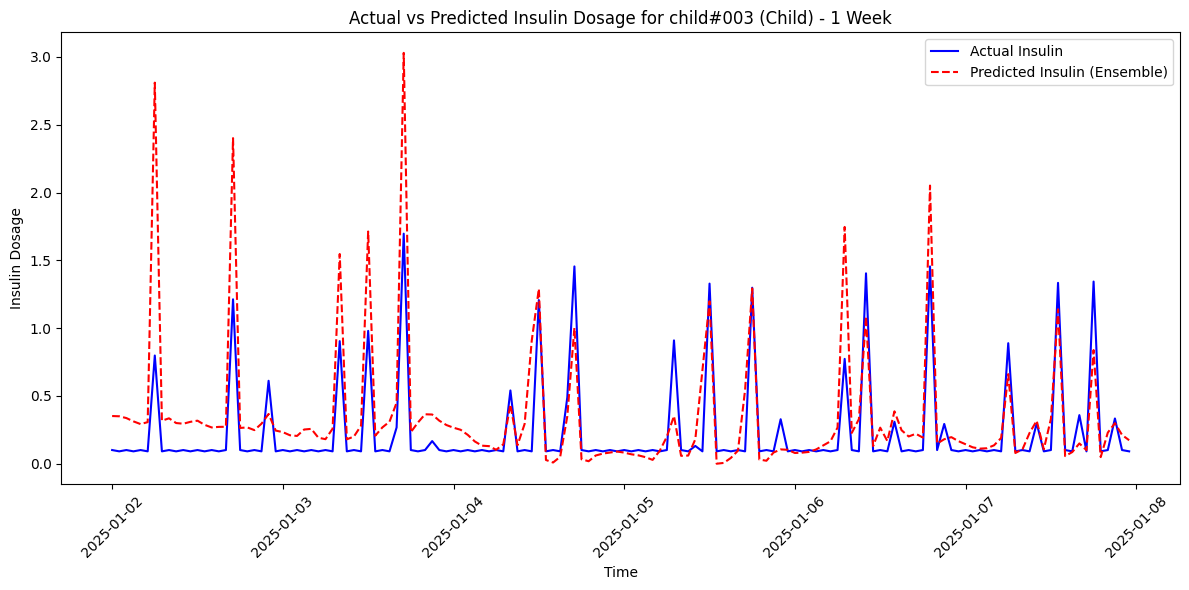

Generating plot for adult#002 in Adult group


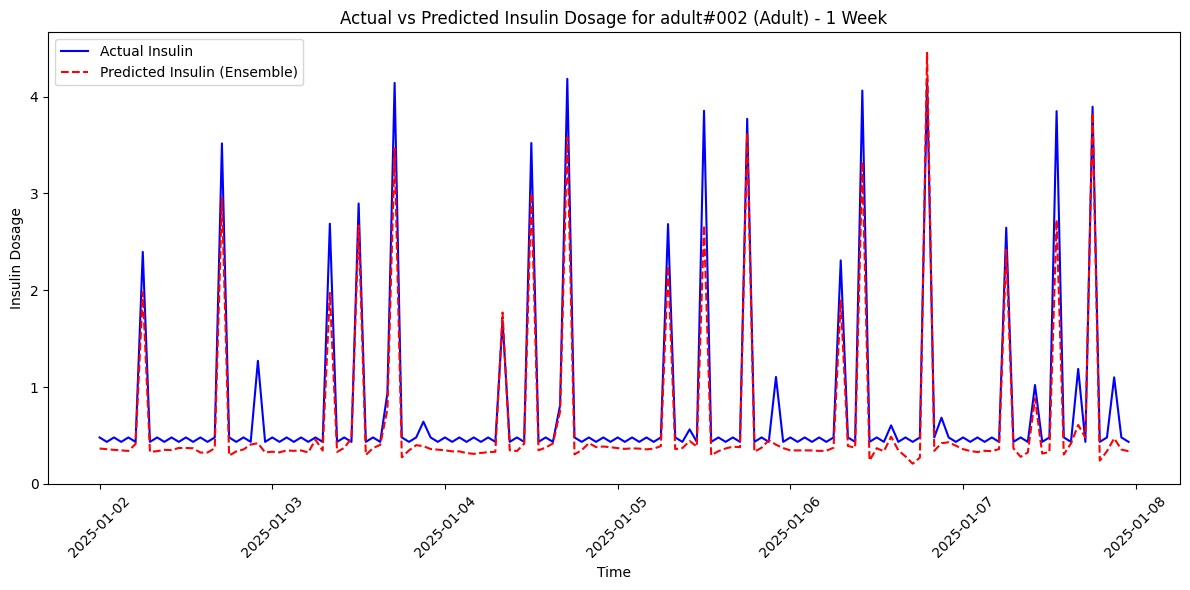

Generating plot for adolescent#010 in Adolescent group


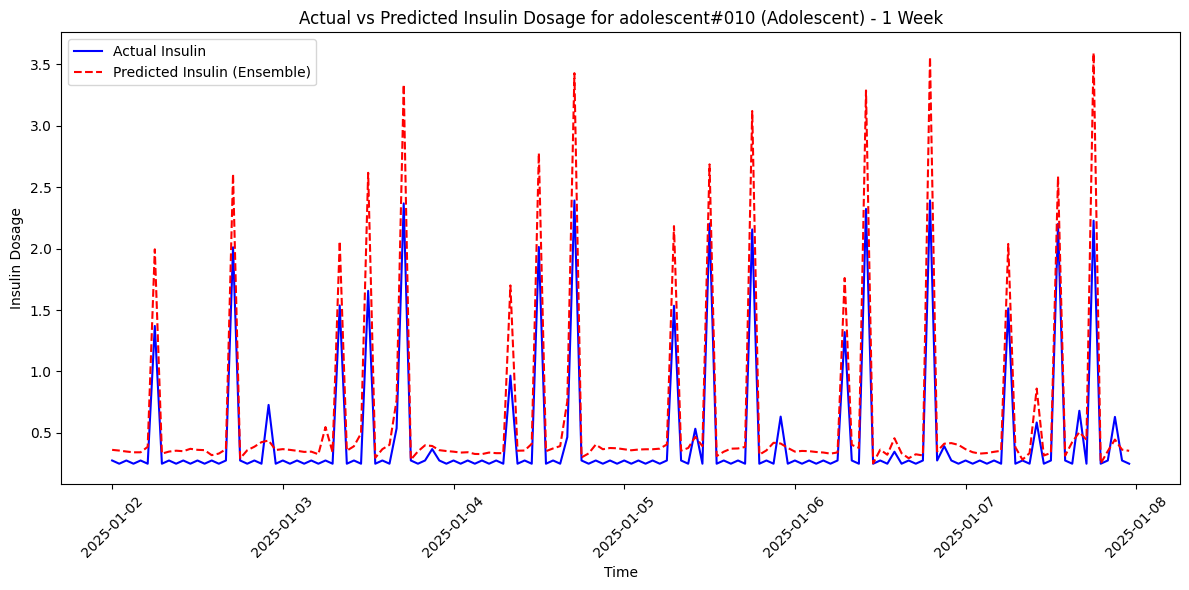

In [ ]:
# Generate plots for sample individuals
groups = ['Child', 'Adult', 'Adolescent']
for group in groups:
    id_column = f"{group}_ID"
    unique_ids = df[df['Group'] == group][id_column].unique()
    for i, individual_id in enumerate(unique_ids[:1]):
        if pd.notna(individual_id):
            print(f"Generating plot for {individual_id} in {group} group")
            plot_actual_vs_predicted_week(individual_id, group)

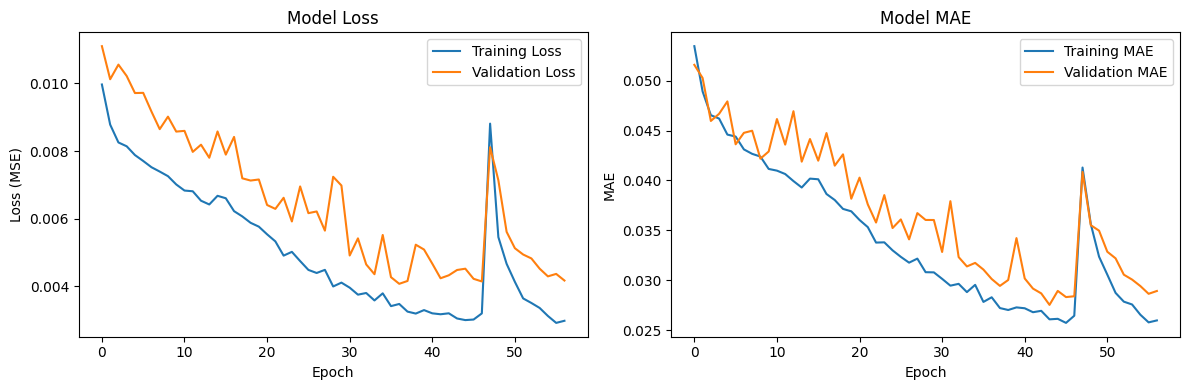

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
weight_lstm = 0.6  # Example: 60% weight to LSTM
weight_gru = 0.4   # Example: 40% weight to GRU

# Verify weights sum to 1
assert abs(weight_lstm + weight_gru - 1.0) < 1e-6, "Weights must sum to 1"

# Print the chosen weights
print(f"Manually assigned weights - LSTM: {weight_lstm:.2f}, GRU: {weight_gru:.2f}")

# Compute weighted ensemble predictions
ensemble_val_preds_manual = (weight_lstm * lstm_val_preds) + (weight_gru * gru_val_preds)
ensemble_test_preds_manual = (weight_lstm * lstm_test_preds) + (weight_gru * gru_test_preds)

# Inverse transform weighted ensemble predictions
ensemble_val_preds_manual_original = scaler_target.inverse_transform(ensemble_val_preds_manual)
ensemble_test_preds_manual_original = scaler_target.inverse_transform(ensemble_test_preds_manual)

# Evaluate the manually weighted ensemble
print_evaluation_metrics(y_val_original, ensemble_val_preds_manual_original, "Validation", "Manually Weighted Ensemble")
print_evaluation_metrics(y_test_original, ensemble_test_preds_manual_original, "Test", "Manually Weighted Ensemble")

Manually assigned weights - LSTM: 0.60, GRU: 0.40

Evaluation Metrics for Validation Set (Manually Weighted Ensemble):
Mean Squared Error (MSE): 0.2360
Mean Absolute Error (MAE): 0.2115
Root Mean Squared Error (RMSE): 0.4858
R² Score: 0.7556

Evaluation Metrics for Test Set (Manually Weighted Ensemble):
Mean Squared Error (MSE): 0.1779
Mean Absolute Error (MAE): 0.1947
Root Mean Squared Error (RMSE): 0.4217
R² Score: 0.7708


In [ ]:
calculate_percentage_within_tolerance(y_val_original, ensemble_val_preds_manual_original,
                                      tolerance=1.0, dataset_name="Validation", model_name="Manually Weighted Ensemble")
calculate_percentage_within_tolerance(y_test_original, ensemble_test_preds_manual_original,
                                      tolerance=1.0, dataset_name="Test", model_name="Manually Weighted Ensemble")


Percentage of predictions within ±1.0 unit for Validation Set (Manually Weighted Ensemble): 95.06%

Percentage of predictions within ±1.0 unit for Test Set (Manually Weighted Ensemble): 95.65%


np.float64(95.64949089787103)

In [ ]:
import os
import pandas as pd
from tensorflow.keras.models import save_model

# Define Google Drive directories
results_dir = "/content/drive/MyDrive/model_sim_data/results"
models_dir = "/content/drive/MyDrive/model_sim_data/models"

# Create directories if they don't exist
os.makedirs(results_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

# Function to save training history to CSV
def save_history_to_csv(history, filename, folder=results_dir):
    history_df = pd.DataFrame(history.history)
    filepath = os.path.join(folder, filename)
    history_df.to_csv(filepath, index_label="Epoch")
    print(f"Saved training history to {filepath}")

# Assuming lstm_history and gru_history are from model.fit()
# Save training history for LSTM and GRU
save_history_to_csv(lstm_history, "lstm_training_history.csv")
save_history_to_csv(gru_history, "gru_training_history.csv")

Saved training history to /content/drive/MyDrive/model_sim_data/results/lstm_training_history.csv
Saved training history to /content/drive/MyDrive/model_sim_data/results/gru_training_history.csv


In [ ]:
# Save the trained models
lstm_model.save(os.path.join(models_dir, "lstm_model.h5"))
gru_model.save(os.path.join(models_dir, "gru_model.h5"))
print(f"Saved LSTM model to {os.path.join(models_dir, 'lstm_model.h5')}")
print(f"Saved GRU model to {os.path.join(models_dir, 'gru_model.h5')}")

Saved LSTM model to /content/drive/MyDrive/model_sim_data/models/lstm_model.h5
Saved GRU model to /content/drive/MyDrive/model_sim_data/models/gru_model.h5


# existing + BI-Gru

In [1]:
#mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from datetime import timedelta

In [3]:
# Load the dataset
data_path = r"/content/drive/MyDrive/model_sim_data/merged-files/final_combined_1month_data_with_time_features.csv"
df = pd.read_csv(data_path)

# Select relevant features for the model
features = ['BG', 'CGM', 'CHO', 'LBGI', 'HBGI', 'Risk', 'Hour_Sin', 'Hour_Cos', 'Is_Weekend']
target = 'insulin'

# Fill missing values
df = df.fillna(method='ffill')

# Ensure 'Rounded_Time' is in datetime format
df['Rounded_Time'] = pd.to_datetime(df['Rounded_Time'])

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/model_sim_data/merged-files/final_combined_1month_data_with_time_features.csv'

In [ ]:
# Scale features and target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

X = scaler_features.fit_transform(df[features].values)
y = scaler_target.fit_transform(df[target].values.reshape(-1, 1))

In [ ]:
# Create sequences
def create_sequences(data, target, time_steps=24):
    X_seq, y_seq = [], []
    for i in range(len(data) - time_steps):
        X_seq.append(data[i:i + time_steps])
        y_seq.append(target[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

time_steps = 24
X_seq, y_seq = create_sequences(X, y, time_steps)

In [ ]:
# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
lstm_model = Sequential([
    Bidirectional(LSTM(512, activation='relu', return_sequences=True),
                  input_shape=(time_steps, len(features))),
    Dropout(0.3),
    Bidirectional(LSTM(256, activation='relu', return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(128, activation='relu', return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64, activation='relu', return_sequences=False)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
lstm_optimizer = Adam(learning_rate=0.0002)  # Slightly lower learning rate for stability
lstm_model.compile(optimizer=lstm_optimizer, loss='mse', metrics=['mae'])

In [ ]:
gru_model = Sequential([
    Bidirectional(GRU(512, activation='relu', return_sequences=True),
                  input_shape=(time_steps, len(features))),
    Dropout(0.3),
    Bidirectional(GRU(256, activation='relu', return_sequences=True)),
    Dropout(0.3),
    Bidirectional(GRU(128, activation='relu', return_sequences=True)),
    Dropout(0.3),
    Bidirectional(GRU(64, activation='relu', return_sequences=False)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

gru_optimizer = Adam(learning_rate=0.0002)  # Slightly lower learning rate for stability
gru_model.compile(optimizer=gru_optimizer, loss='mse', metrics=['mae'])

In [ ]:
# Update EarlyStopping patience for deeper models
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

In [ ]:
lstm_history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # Increase epochs to allow deeper model convergence
    batch_size=32,  # Smaller batch size for finer updates
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 57s 80ms/step - loss: 0.0102 - mae: 0.0529 - val_loss: 0.0120 - val_mae: 0.0482
Epoch 2/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 60s 54ms/step - loss: 0.0085 - mae: 0.0482 - val_loss: 0.0103 - val_mae: 0.0469
Epoch 3/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - loss: 0.0081 - mae: 0.0465 - val_loss: 0.0097 - val_mae: 0.0469
Epoch 4/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - loss: 0.0083 - mae: 0.0462 - val_loss: 0.0098 - val_mae: 0.0511
Epoch 5/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - loss: 0.0076 - mae: 0.0442 - val_loss: 0.0093 - val_mae: 0.0463
Epoch 6/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - loss: 0.0078 - mae: 0.0448 - val_loss: 0.0094 - val_mae: 0.0447
Epoch 7/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - loss: 0.0075 - mae: 0.0428 - val_loss: 0.0089 - val_mae: 0.0477
Epoch 8/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - loss: 0.0074 - mae: 0.0429 - val_loss: 0.0090 - val_mae: 0.0434
Epoch 9/100
473/473 ━━━━━━━━━━━━

In [ ]:
import sys
import tensorflow as tf

# Check Python version
print("Python version:", sys.version)

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

Python version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
TensorFlow version: 2.18.0


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

# Get predictions from both models
lstm_val_preds = lstm_model.predict(X_val, verbose=0)
lstm_test_preds = lstm_model.predict(X_test, verbose=0)
# Evaluation Metrics Function
def print_evaluation_metrics(y_true, y_pred, dataset_name="", model_name=""):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\nEvaluation Metrics for {dataset_name} Set ({model_name}):")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

# Percentage within ±1 unit Function
def calculate_percentage_within_tolerance(y_true, y_pred, tolerance=1.0, dataset_name="", model_name=""):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    differences = np.abs(y_true - y_pred)
    within_tolerance = np.sum(differences <= tolerance)
    total_instances = len(y_true)
    percentage = (within_tolerance / total_instances) * 100
    print(f"\nPercentage of predictions within ±{tolerance} unit for {dataset_name} Set ({model_name}): {percentage:.2f}%")
    return percentage

In [ ]:
# Get predictions from both models
lstm_val_preds = lstm_model.predict(X_val, verbose=0)
lstm_test_preds = lstm_model.predict(X_test, verbose=0)


# Inverse transform predictions and actual values
lstm_val_preds_original = scaler_target.inverse_transform(lstm_val_preds)
lstm_test_preds_original = scaler_target.inverse_transform(lstm_test_preds)

y_val_original = scaler_target.inverse_transform(y_val)
y_test_original = scaler_target.inverse_transform(y_test)

In [ ]:
# Evaluate LSTM Model
print_evaluation_metrics(y_val_original, lstm_val_preds_original, "Validation", "LSTM")
print_evaluation_metrics(y_test_original, lstm_test_preds_original, "Test", "LSTM")
calculate_percentage_within_tolerance(y_val_original, lstm_val_preds_original, tolerance=1.0, dataset_name="Validation", model_name="LSTM")
calculate_percentage_within_tolerance(y_test_original, lstm_test_preds_original, tolerance=1.0, dataset_name="Test", model_name="LSTM")



Evaluation Metrics for Validation Set (LSTM):
Mean Squared Error (MSE): 0.2403
Mean Absolute Error (MAE): 0.2030
Root Mean Squared Error (RMSE): 0.4902
R² Score: 0.7512

Evaluation Metrics for Test Set (LSTM):
Mean Squared Error (MSE): 0.1616
Mean Absolute Error (MAE): 0.1771
Root Mean Squared Error (RMSE): 0.4020
R² Score: 0.7917

Percentage of predictions within ±1.0 unit for Validation Set (LSTM): 95.34%

Percentage of predictions within ±1.0 unit for Test Set (LSTM): 96.11%


np.float64(96.11231101511879)

In [ ]:
gru_history = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,  # Smaller batch size for finer updates
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 35s 73ms/step - loss: 0.0098 - mae: 0.0515 - val_loss: 0.0110 - val_mae: 0.0471
Epoch 2/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.0087 - mae: 0.0474 - val_loss: 0.0107 - val_mae: 0.0501
Epoch 3/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.0077 - mae: 0.0449 - val_loss: 0.0098 - val_mae: 0.0463
Epoch 4/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 0.0084 - mae: 0.0459 - val_loss: 0.0094 - val_mae: 0.0489
Epoch 5/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 0.0074 - mae: 0.0428 - val_loss: 0.0093 - val_mae: 0.0474
Epoch 6/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.0078 - mae: 0.0438 - val_loss: 0.0091 - val_mae: 0.0453
Epoch 7/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - loss: 0.0074 - mae: 0.0430 - val_loss: 0.0091 - val_mae: 0.0441
Epoch 8/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - loss: 0.0074 - mae: 0.0431 - val_loss: 0.0086 - val_mae: 0.0433
Epoch 9/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import os
lstm_model.save(os.path.join(models_dir, "deep_lstm_model.h5"))
gru_model.save(os.path.join(models_dir, "deep_gru_model.h5"))
save_history_to_csv(lstm_history, "deep_lstm_training_history.csv")
save_history_to_csv(gru_history, "deep_gru_training_history.csv")

NameError: name 'models_dir' is not defined

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

# Get predictions from both models
lstm_val_preds = lstm_model.predict(X_val, verbose=0)
lstm_test_preds = lstm_model.predict(X_test, verbose=0)
gru_val_preds = gru_model.predict(X_val, verbose=0)
gru_test_preds = gru_model.predict(X_test, verbose=0)

# Inverse transform predictions and actual values
lstm_val_preds_original = scaler_target.inverse_transform(lstm_val_preds)
lstm_test_preds_original = scaler_target.inverse_transform(lstm_test_preds)
gru_val_preds_original = scaler_target.inverse_transform(gru_val_preds)
gru_test_preds_original = scaler_target.inverse_transform(gru_test_preds)
y_val_original = scaler_target.inverse_transform(y_val)
y_test_original = scaler_target.inverse_transform(y_test)

In [ ]:
# Evaluation Metrics Function
def print_evaluation_metrics(y_true, y_pred, dataset_name="", model_name=""):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\nEvaluation Metrics for {dataset_name} Set ({model_name}):")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

# Percentage within ±1 unit Function
def calculate_percentage_within_tolerance(y_true, y_pred, tolerance=1.0, dataset_name="", model_name=""):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    differences = np.abs(y_true - y_pred)
    within_tolerance = np.sum(differences <= tolerance)
    total_instances = len(y_true)
    percentage = (within_tolerance / total_instances) * 100
    print(f"\nPercentage of predictions within ±{tolerance} unit for {dataset_name} Set ({model_name}): {percentage:.2f}%")
    return percentage

In [ ]:
# Evaluate LSTM Model
print_evaluation_metrics(y_val_original, lstm_val_preds_original, "Validation", "LSTM")
print_evaluation_metrics(y_test_original, lstm_test_preds_original, "Test", "LSTM")
calculate_percentage_within_tolerance(y_val_original, lstm_val_preds_original, tolerance=1.0, dataset_name="Validation", model_name="LSTM")
calculate_percentage_within_tolerance(y_test_original, lstm_test_preds_original, tolerance=1.0, dataset_name="Test", model_name="LSTM")

# Evaluate GRU Model
print_evaluation_metrics(y_val_original, gru_val_preds_original, "Validation", "GRU")
print_evaluation_metrics(y_test_original, gru_test_preds_original, "Test", "GRU")
calculate_percentage_within_tolerance(y_val_original, gru_val_preds_original, tolerance=1.0, dataset_name="Validation", model_name="GRU")
calculate_percentage_within_tolerance(y_test_original, gru_test_preds_original, tolerance=1.0, dataset_name="Test", model_name="GRU")


Evaluation Metrics for Validation Set (LSTM):
Mean Squared Error (MSE): 0.2403
Mean Absolute Error (MAE): 0.2030
Root Mean Squared Error (RMSE): 0.4902
R² Score: 0.7512

Evaluation Metrics for Test Set (LSTM):
Mean Squared Error (MSE): 0.1616
Mean Absolute Error (MAE): 0.1771
Root Mean Squared Error (RMSE): 0.4020
R² Score: 0.7917

Percentage of predictions within ±1.0 unit for Validation Set (LSTM): 95.34%

Percentage of predictions within ±1.0 unit for Test Set (LSTM): 96.11%

Evaluation Metrics for Validation Set (GRU):
Mean Squared Error (MSE): 0.2556
Mean Absolute Error (MAE): 0.2272
Root Mean Squared Error (RMSE): 0.5056
R² Score: 0.7353

Evaluation Metrics for Test Set (GRU):
Mean Squared Error (MSE): 0.2015
Mean Absolute Error (MAE): 0.2080
Root Mean Squared Error (RMSE): 0.4489
R² Score: 0.7403

Percentage of predictions within ±1.0 unit for Validation Set (GRU): 94.85%

Percentage of predictions within ±1.0 unit for Test Set (GRU): 95.53%


np.float64(95.5260721999383)

In [ ]:
# Define weights for the weighted ensemble
weight_lstm = 0.7
weight_gru = 0.3

# Verify weights sum to 1
assert abs(weight_lstm + weight_gru - 1.0) < 1e-6, "Weights must sum to 1"

# Print the chosen weights
print(f"\nManually assigned weights - LSTM: {weight_lstm:.2f}, GRU: {weight_gru:.2f}")


Manually assigned weights - LSTM: 0.70, GRU: 0.30


In [ ]:
# Compute weighted ensemble predictions
ensemble_val_preds_manual = (weight_lstm * lstm_val_preds) + (weight_gru * gru_val_preds)
ensemble_test_preds_manual = (weight_lstm * lstm_test_preds) + (weight_gru * gru_test_preds)

# Inverse transform weighted ensemble predictions
ensemble_val_preds_manual_original = scaler_target.inverse_transform(ensemble_val_preds_manual)
ensemble_test_preds_manual_original = scaler_target.inverse_transform(ensemble_test_preds_manual)

# Evaluate Weighted Ensemble Model
print_evaluation_metrics(y_val_original, ensemble_val_preds_manual_original, "Validation", "Manually Weighted Ensemble")
print_evaluation_metrics(y_test_original, ensemble_test_preds_manual_original, "Test", "Manually Weighted Ensemble")
calculate_percentage_within_tolerance(y_val_original, ensemble_val_preds_manual_original, tolerance=1.0, dataset_name="Validation", model_name="Manually Weighted Ensemble")
calculate_percentage_within_tolerance(y_test_original, ensemble_test_preds_manual_original, tolerance=1.0, dataset_name="Test", model_name="Manually Weighted Ensemble")


Evaluation Metrics for Validation Set (Manually Weighted Ensemble):
Mean Squared Error (MSE): 0.2271
Mean Absolute Error (MAE): 0.2023
Root Mean Squared Error (RMSE): 0.4766
R² Score: 0.7648

Evaluation Metrics for Test Set (Manually Weighted Ensemble):
Mean Squared Error (MSE): 0.1514
Mean Absolute Error (MAE): 0.1753
Root Mean Squared Error (RMSE): 0.3891
R² Score: 0.8049

Percentage of predictions within ±1.0 unit for Validation Set (Manually Weighted Ensemble): 95.40%

Percentage of predictions within ±1.0 unit for Test Set (Manually Weighted Ensemble): 96.54%


np.float64(96.54427645788337)

In [ ]:
# Define Google Drive directories
pp_models_dir = "/content/drive/MyDrive/model_sim_data/pp_models"
pp_results_dir = "/content/drive/MyDrive/model_sim_data/pp_results"

In [ ]:
# Create directories if they don't exist
os.makedirs(pp_models_dir, exist_ok=True)
os.makedirs(pp_results_dir, exist_ok=True)

# Function to save training history to CSV
def save_history_to_csv(history, filename, folder=pp_results_dir):
    history_df = pd.DataFrame(history.history)
    filepath = os.path.join(folder, filename)
    history_df.to_csv(filepath, index_label="Epoch")
    print(f"Saved training history to {filepath}")

# Save training history for LSTM and GRU
save_history_to_csv(lstm_history, "deep_lstm_training_history.csv")
save_history_to_csv(gru_history, "deep_gru_training_history.csv")

# Save the trained models
lstm_model.save(os.path.join(pp_models_dir, "deep_lstm_model.h5"))
gru_model.save(os.path.join(pp_models_dir, "deep_gru_model.h5"))
print(f"Saved LSTM model to {os.path.join(pp_models_dir, 'deep_lstm_model.h5')}")
print(f"Saved GRU model to {os.path.join(pp_models_dir, 'deep_gru_model.h5')}")

Saved training history to /content/drive/MyDrive/model_sim_data/pp_results/deep_lstm_training_history.csv
Saved training history to /content/drive/MyDrive/model_sim_data/pp_results/deep_gru_training_history.csv


Saved LSTM model to /content/drive/MyDrive/model_sim_data/pp_models/deep_lstm_model.h5
Saved GRU model to /content/drive/MyDrive/model_sim_data/pp_models/deep_gru_model.h5


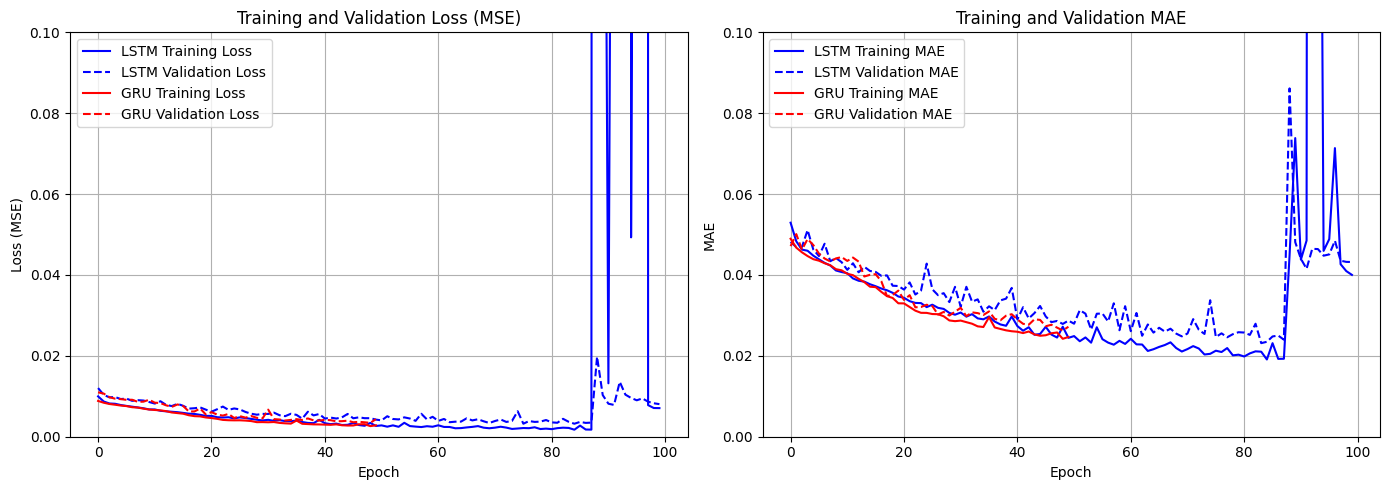

In [ ]:
import matplotlib.pyplot as plt

# Plot training history for LSTM and GRU directly from history objects
plt.figure(figsize=(14, 5))

# Plot 1: Training and Validation Loss (MSE)
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['loss'], label='LSTM Training Loss', color='blue')
plt.plot(lstm_history.history['val_loss'], label='LSTM Validation Loss', color='blue', linestyle='--')
plt.plot(gru_history.history['loss'], label='GRU Training Loss', color='red')
plt.plot(gru_history.history['val_loss'], label='GRU Validation Loss', color='red', linestyle='--')
plt.title('Training and Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.ylim(0, 0.1)  # Set y-axis range from 0 to 10
plt.legend()
plt.grid(True)

# Plot 2: Training and Validation MAE
plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['mae'], label='LSTM Training MAE', color='blue')
plt.plot(lstm_history.history['val_mae'], label='LSTM Validation MAE', color='blue', linestyle='--')
plt.plot(gru_history.history['mae'], label='GRU Training MAE', color='red')
plt.plot(gru_history.history['val_mae'], label='GRU Validation MAE', color='red', linestyle='--')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.ylim(0, 0.1)  # Set y-axis range from 0 to 10
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#practical testing the model

In [ ]:
# Example: Last known 6 hours of data (replace this with your actual data)
last_known_data = [
    [110, 100, 20, 3.5, 4.2, 12, 0.5, 0.5, 0],
    [115, 105, 25, 4.0, 3.8, 10, 0.6, 0.4, 0],
    [120, 110, 15, 3.8, 4.5, 8, 0.7, 0.3, 1],
    [118, 108, 22, 3.9, 4.0, 9, 0.8, 0.2, 1],
    [125, 112, 18, 3.7, 4.3, 7, 0.9, 0.1, 0],
    [122, 110, 20, 3.6, 4.4, 8, 1.0, 0.0, 0],
]
last_known_data = np.array(last_known_data)

# Scale the last known data using the fitted scaler
scaled_last_known_data = scaler_features.transform(last_known_data)

# Initialize the sequence for prediction
current_sequence = scaled_last_known_data
predictions = []


In [ ]:

# Generate predictions for the next 12 hours
for _ in range(12):
    # Expand dimensions to match model input shape: (1, time_steps, n_features)
    input_sequence = np.expand_dims(current_sequence, axis=0)

    # Predict the next insulin level
    next_prediction = model.predict(input_sequence)

    # Store the prediction (inverse transform to get the actual value)
    predictions.append(scaler_target.inverse_transform(next_prediction)[0, 0])

    # Update the sequence: Remove the first row, append the prediction
    next_row = np.zeros(current_sequence.shape[1])  # Placeholder for the new row
    next_row[:-1] = current_sequence[-1, :-1]  # Copy features except insulin
    next_row[-1] = next_prediction[0, 0]  # Append the predicted insulin level

    current_sequence = np.vstack((current_sequence[1:], next_row))

# Print predictions
for i, prediction in enumerate(predictions):
    print(f"Prediction for hour {i + 1}: {prediction:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for hour 1: 0.06
Prediction for hour 2: 0.11
Prediction for hour 3: 0.11
Prediction for hour 4: 0.11
Prediction for hour 5: 0.13
Prediction for hour 6: 0.13
Prediction for hour 7: 0.13
Prediction for hour 8: 0.13
Prediction for hour 9: 0.13
Prediction for hour 10: 0.13
Prediction for hour 11: 0.13
Prediction for hour 12: 0.13


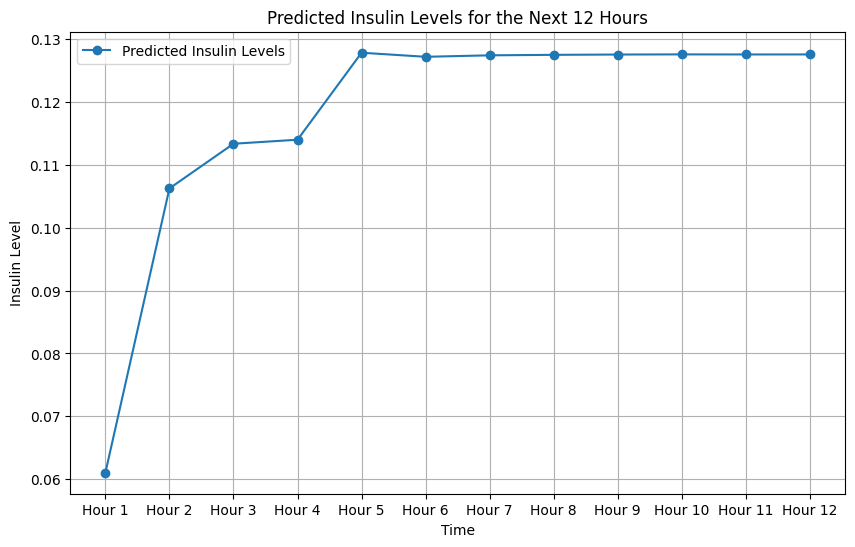

In [ ]:
import matplotlib.pyplot as plt

# Example timestamps for the next 12 hours
timestamps = [f'Hour {i + 1}' for i in range(12)]

# Plot predictions
plt.figure(figsize=(10, 6))
plt.plot(timestamps, predictions, marker='o', label='Predicted Insulin Levels')
plt.xlabel('Time')
plt.ylabel('Insulin Level')
plt.title('Predicted Insulin Levels for the Next 12 Hours')
plt.legend()
plt.grid()
plt.show()


#upgrade code


In [ ]:
#mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
# Load the dataset
data_path = "/content/drive/MyDrive/model_sim_data/merged-files/final_combined_data_with_time_features.csv"
try:
    df = pd.read_csv(data_path)
    print(f"Dataset loaded successfully. Shape: {df.shape}")
except FileNotFoundError:
    raise FileNotFoundError(f"File not found at {data_path}. Check the path.")
except Exception as e:
    raise Exception(f"Error loading dataset: {e}")

Dataset loaded successfully. Shape: (500, 16)


In [ ]:
# Print initial column names and missing values
print("Columns in dataset:", df.columns.tolist())
print("Missing values per column:\n", df.isnull().sum())

# Feature engineering: Add lagged insulin values
for lag in range(1, 4):
    df[f'insulin_lag_{lag}'] = df['insulin'].shift(lag)

# Updated feature list
features = ['BG', 'CGM', 'CHO', 'LBGI', 'HBGI', 'Risk', 'Hour_Sin', 'Hour_Cos', 'Is_Weekend',
            'insulin_lag_1', 'insulin_lag_2', 'insulin_lag_3']
target = 'insulin'

Columns in dataset: ['Rounded_Time', 'Child_ID', 'Group', 'BG', 'CGM', 'CHO', 'insulin', 'LBGI', 'HBGI', 'Risk', 'Hour', 'Day_of_Week', 'Is_Weekend', 'Hour_Sin', 'Hour_Cos', 'Adult_ID']
Missing values per column:
 Rounded_Time      0
Child_ID        250
Group             0
BG                0
CGM               0
CHO               0
insulin           0
LBGI              0
HBGI              0
Risk              0
Hour              0
Day_of_Week       0
Is_Weekend        0
Hour_Sin          0
Hour_Cos          0
Adult_ID        250
dtype: int64


In [ ]:
# Check if DataFrame is empty
if df.empty:
    raise ValueError("DataFrame is empty after preprocessing. Check your dataset.")

# Separate features and target
X = df[features].values
y = df[target].values

ValueError: DataFrame is empty after preprocessing. Check your dataset.

In [ ]:
# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define an improved LSTM model
model = Sequential([
    LSTM(128, activation='relu', input_shape=(time_steps, len(features)), return_sequences=True),
    Dropout(0.2),  # Add dropout to prevent overfitting
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  # Output layer for regression
])

In [ ]:
# Compile with a custom learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # Increased epochs for better convergence
    batch_size=16,  # Smaller batch size for finer updates
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

In [ ]:
# Evaluate the model with R² score
y_pred_test = model.predict(X_test)
y_pred_test_inv = scaler_target.inverse_transform(y_pred_test)
y_test_inv = scaler_target.inverse_transform(y_test)
r2 = r2_score(y_test_inv, y_pred_test_inv)
print(f"R² Score on Test Set: {r2:.4f}")

In [ ]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()